# Instruction Notebook (259 samples)

### Author: Yunus Shariff 
**Email:** shariff.yunus96@gmail.com

Scripts tested in `Python 3.12.2` as of **07/08/24**

The cumulative goal of this project is to further the research from [In-Home Mobility Frequency and Stability in Older Adults Living Alone With or Without MCI: Introduction of New Metrics](https://www.frontiersin.org/journals/digital-health/articles/10.3389/fdgth.2021.764510/full) by `Chao-Yi Wu, et al.` 

In lieu of standardized test scores, which can yield highly accurate results, the focus is to quantify behavioral patterns, group differences (gender, geography, race, etc.,) and/or feature interactions collected from monitoring the daily living habits of older adults to reliably detect MCI (Mild Cognitive Impairment), which may occur as a transitional stage between normal aging and dementia. MCI may include problems with memory, language or judgement.

This notebook contains instructions for the following sections/scripts 

1. Demographic data: Read demographic data for OHSU, VA, RUSH and OLL, with minimal filtering and exclusion inorder to retain demographic information for larger sample size of 265 participants
2. Sleep and Step Data: Read daily step & sleep data and output daily step-sleep data enriched with demographic details
3. Additional features Calculation (and transformation): Compute Interdaily Stability and Interdaily Variability of steps from hourly data, apply transformations as needed. Still generates weekly average for IV and IS. Also std and coefficient of variation are calculated for daily sleep data in lieu of IV and IS
5. Predictions: Using daily data, classify subject between two classes, namely, MCI (Mild Cognitive Impairment) or Normal cognition.

Note: `ProcessSensor.py` script is excluded as survey data is weekly and does not cover all subids, survey features such as MED, FALL, HTH, ACDT (medication, fall, hospitalization, accident,...) are rare life events and cannot be used for classification task. Survey data was also found to be noisy in our testing. Due to this, our feature set also does not include longer has trips, outdoor time, IV & IS of room-to-room transitions

In [1]:
from platform import python_version

print(f"This machine uses python {python_version()}") 

This machine uses python 3.12.2


## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
from itertools import compress
from collections import Counter

# Survey/Room Sensor analyses
import datetime as dt
from datetime import date, datetime
from datetime import timedelta
from numpy.polynomial.polynomial import polyfit
import matplotlib.patches as mpatches
import math
from astropy.modeling import models, fitting

# Model training
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc 
from sklearn.impute import KNNImputer, SimpleImputer
from xgboost import XGBClassifier

# Model evaulation
from sklearn import tree 
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix

# Feature analyses
from scipy import stats
from sklearn.linear_model import LinearRegression
import shap
import statsmodels.api as sm # SHAP analysis (p-value, model coefficient)
from scipy.stats import ttest_ind # for group differences (if any feature(s) contribute towards class separation)
from math import ceil, log # for histograms & log tranform


pd.set_option('display.max_rows',150) # set max rows display to 150

## Function definitions

In [3]:
def update_dtypes(df, column_list, category_type):
    """
    update the category of the columns provided in `df`
    category_type: str i.e., list of columns will be updated to the same category type
    """
    for col in column_list:
        
        if category_type == 'category' and type(df.loc[0,col])!= str:
            df.loc[:,col] = df[col].astype('int64') 

        df.loc[:,col] = df[col].astype(category_type)


In [4]:
def reqd_directories(folder_num: str):
    """
    returns directories and subdirectories (if any) by matching folder substring

    folder_num (input): Folder substring (user specified), to locate appropriate directory
                     
    dict_rootlen: dictionary to store path and corresponding length of path string
    dict_subdir: dictionary to store root path and corresponding list of subdirectionaries

    parent_folder_path (output): the path for the parent folder, which contains `folder_num` in its name
    dict_subdir[parent_folder_path] (output): the path of subdirectories which exist in the matched parent folder above
    """

    dict_rootlen = dict() # stores len of the path string for each path string matched with  `folder_num`
    dict_subdir = dict()  # stores list of subdirectory names corresponding to paths containing `folder_num`

    for root, dirs, files in os.walk(os.getcwd(), topdown = False):
        if folder_num in root: # root is any path that contains  `folder_num`. This can be parent folder path, first-level subdirectories and innermost child (sub) directories
            dict_rootlen[root] = len(root) # we store the length of each matched path string; parent folder path will have the shortest length i.e., least amount of characters
            if dirs: 
                dirs.sort() # if subdirectories exist, sort them alphabetically and save them wrt the appropriate folder path; we only export the first-level subdirectories
                dict_subdir[root] = dirs

    parent_folder_path = [key for key in dict_rootlen.keys() if dict_rootlen[key] == min(dict_rootlen.values())][-1]

    if not dict_subdir: # if there are no subdirectories export parent folder path alone
        return parent_folder_path
    else: 
        return parent_folder_path, dict_subdir[parent_folder_path] # export parent folder path & list of first-level subdirectories 

### Process Sensor functions

In [5]:
def compute_diff(df, cols):
    """
    Compute difference between datetime columns and return updated df.
    Used to determine the number of days a subject may have been away from home (vacation/emergency) or had visitors.
    
    df(input): dataframe shape(_,3) containing dates from completed surveys indicating participants were either away or had visitors. 
    
    cols: datetime columns expected as [start_of_visit, end_of_visit, recorded_date], i.e., [VIS1_ARR, VIS1_LEAVE, RecordedDate]
          or [AWAY1_LEAVE, AWAY1_RET, RecordedDate]

    df(output): input df shape concatenated with "difference columns" w/ shape (_,5) i.e., 
                [start_of_visit, end_of_visit, recorded_date, diff_visit_days, diff_visit_end_date_and_recorded_date]

    """
    
    temp = pd.DataFrame()
    name = cols[0][:3] # name = "VIS1" from [VIS1_ARR, VIS1_LEAVE, RecordedDate] or "AWAY1" from [AWAY1_LEAVE, AWAY1_RET, RecordedDate]
    
    temp[[f'Diff_{name}',f'Diff_{name}_Rec']] = df[cols].diff(axis = 1).iloc[:,1:] # extract (VIS1_LEAVE - VIS1_ARR) & (RecordedDate - VIS1_LEAVE)
    temp = pd.concat([(temp[f'Diff_{name}']).dt.days, (temp[f'Diff_{name}_Rec']).dt.days],axis =1) # formatting 
    df = pd.concat([df,temp], axis = 1) # append the computed columns to the input dataframe

    # exclude dates where participants may have swapped departure and arrival dates in the questionnaire
    df = df[(df[f'Diff_{name}']>-1) & (df[f'Diff_{name}_Rec']>-1)].reset_index(drop = True) 
     
    return df


In [6]:
def unique_dates(list_name, dict_name):
    """
    Aggregate dates identified in weekly questionnaires for each participant

    list_name: list of dictionaries, each containing one key (homeid), pointing to a list of dates. 
    dict_name: single dictionary containing multiple keys (homeids) pointing to a consoldated list of dates, corresponding to that homeid
       
    Since we have several dates for each participant (homeid), list_name contains several dicts for the same homeid pointing to several lists
    of dates. The goal is to clean up these duplicates and create a single dictionary where each of the homeids is a unique keys consolidating
    all the dates relevant to that homeid as corresponding items
    
    """
    for dic in list_name: # iterate over each dict in list_name
        for lis in dic: # each dict only has one key (homeid). If homeid found already exists in target, append dates, else create new entry
            if lis in dict_name:
                dict_name[lis] += (dic[lis])
            else:
                dict_name[lis] = dic[lis]


def Daylight(latitude,day):
    """
    Get the amount of daylight per day per site using latitude
    """
    P = math.asin(0.39795 * math.cos(0.2163108 + 2 * math.atan(0.9671396 * math.tan(.00860 * (day - 186)))))
    pi = math.pi
    daylightamount = 24 - (24 / pi) * math.acos(
        (math.sin((0.8333 * pi / 180) + math.sin(latitude * pi / 180) * math.sin(P)) / (math.cos(latitude * pi / 180) * math.cos(P))))
    return daylightamount

### Sleep and Step data functions

In [7]:
def IS_calc(df, outcome, h_var):
    """
    Calculate Interdaily stability (IS) - only works if we have hourly granularity of the outcome (feature of interest).
    IS is a measure of stability of the outcome (steps) over the duration of observation (week) by comparing patterns from each day to the 
    avg pattern across the total number of days (week)
    
    df: df w/ steps logged every hour for pre-specified duration (e.g., week) for a particular subject (sorted by date & hour)
    h_var: feature denoting hour marker (1, 2,..., 24)
    outcome: the feature (steps) whose interdaily stability must be determined
    
    """
    df_len = len(df)
    if df_len > 0:
        
        h_len = df[h_var].nunique() # will be 24 since df is interpolated for any missing dates (and hours) within the desired window (week)
        out_mean = df[outcome].mean() # mean value of steps for the duration of data available
        h_error = sum(np.square(df.groupby(h_var)[outcome].mean() - out_mean)) # SSE of mean steps (grouped by hour) & weekly mean
        k_error = sum(np.square(df[outcome] - out_mean))  # SSE of steps & weekly mean
        if k_error!=0: 
            value = (df_len * h_error) / (h_len * k_error) # compute IS 
            return value
    else:
        return np.nan # if no data is available 

    
def IV_calc(df, outcome, h_var):
    """
    Calculate Interdaily variability (IV) - only works if we have hourly granularity of the outcome (feature of interest).
    IV is a measure of variation in the outcome (steps) over the duration of observation (week) by comparing patterns from each day to the 
    avg pattern across the total number of days (week)

    df: df w/ steps logged every hour for pre-specified duration (e.g., week) for a particular subject (sorted by date & hour)
    h_var: feature denoting hour marker (1, 2,..., 24)
    outcome: the feature (steps) whose interdaily variability must be determined
    
    """
    df_len = len(df)
    
    if df_len > 0:
        
        list1 = df[outcome].iloc[:-1].tolist() # index 0 to index (n-1) steps 
        list2 = df[outcome].iloc[1:].tolist() # index 1 to index n steps; to perform diff of steps b/w subsequent hours 
        error = [np.square(ele1 - ele2) for (ele1, ele2) in zip(list1, list2)] # Squared error of steps between every hour 
        sum_error = sum(error) # SSE of hourly steps

        out_mean = df[outcome].mean() # weekly mean of steps 
        k_error = sum(np.square(df[outcome] - out_mean)) # SSE of steps & weekly mean 
        if k_error!=0: 
            value = (df_len * sum_error) / ((df_len - 1)*k_error) # compute IV
            return value
        
    else:
        return np.nan # if no data is available 
    
    

### Additional features calculation functions

In [8]:
# Define a function to calculate weekly averages
def calculate_weekly_average(row):
    """
    Appends average weekly "chunked" steps to the each row of df calling this fn.
    This fn only filters chunked_df based on date. 
    
    chunked_df is generated from hourly step data before this function is called. It is a condensed version of hourly data.
    
    chunked_df: each row corresponds to total daily steps for a participant dissected into four 6 hr groups (morning, afternoon, evening & midnight).
                Generated from hourly step data. If the hour at which steps recorded lies between midnight & 6am, it's classified as 
                "midnight steps", similarly steps between 6am and 12pm are "morning steps"... 

                
    
    """
    
    subid = row['subid']
    report_date = row['report_date']
    
    # Filter all_hourly_data (df w/ hourly data) for the past 7 days from report_date
    past_7_days = chunked_df[(chunked_df['subid'] == subid) &
                                  (pd.to_datetime(chunked_df['date']) >= pd.to_datetime(report_date) - timedelta(days=8)) &
                                  (pd.to_datetime(chunked_df['date']) < pd.to_datetime(report_date))]
    
    # Calculate the average of the selected time intervals
    weekly_avg = past_7_days[['midnight_steps', 'morning_steps', 'afternoon_steps', 'evening_steps']].mean()
    return pd.Series(weekly_avg, index=['midnight_steps', 'morning_steps', 'afternoon_steps', 'evening_steps'])

In [9]:
def transform_steps(ser, transform:str):

    """
    ser: series of steps to be transformed
    transform: name of transform to be applied = log (natural log), sqrt, cbrt
    trans_ser: return transformed steps
    """
    

    prefix = transform
    
    if prefix == 'sqrt':
        trans_ser = ser.apply(lambda x: np.sqrt(x))
    
    elif prefix == 'log':
        delta = 1
        trans_ser = ser.apply(lambda x: math.log(x) if x!=0 else math.log(delta))
    
    elif prefix == 'cbrt':
        trans_ser = ser.apply(lambda x: np.cbrt(x))


    return pd.Series(trans_ser, name =f'{prefix}_steps')



### T-test functions

In [10]:
def avg_desired_weeks(df_with_date, period = 7):
    """
    df_with_date: df containing `date` column  
    period: no of days from first date (range of dates) for which avg is calculated. Default=7
    
    avg_df: df with aggregated values, based on period (default avg of first week), to be used for t-test. Dates dropped to compute aggregates
    """
    avg_df = pd.DataFrame()
    
    for id in df_with_date['subid'].unique(): # parse through each subid
        subset = df_with_date[df_with_date['subid'] == id].reset_index(drop = True)
        start_of_week = subset.loc[subset.index[0],'report_date'] # data is sorted by 'report_date', use first entry to determine first week
        
        first_week = pd.date_range(start_of_week,periods = period)
        first_week_df = subset[subset['report_date'].isin(first_week)].drop_duplicates(subset='report_date',keep='first').drop('report_date',axis=1) # drop date
        
        avg_df = pd.concat([avg_df,first_week_df.mean()], axis = 1) # date dropped to compute mean
        
    avg_df = avg_df.T.reset_index(drop = True)

    
    return avg_df


### Predictions functions

In [11]:
def preprocessing(imputed_df, encode_cols):
    """
    Perform standard scaling (z-score normalization) of numerical features, one-hot encode desired columns (encode_cols), and return
    along with unaltered (integer & binary categorical) columns in the output dataframe
    
    imputed_df: X_train or X_test after filling strategy
    encode_cols: Categorical columns to be one-hot encoded 

    """

    numerical_cols = imputed_df.columns[imputed_df.dtypes == 'float64'].tolist()

    # z-score normalization
    standard_scaler = StandardScaler()
    df_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(imputed_df[numerical_cols]), columns=numerical_cols)

    df_encoded = pd.DataFrame() # stores encoded columns
    
    # Iterate over each column and apply one-hot encoding
    for col in encode_cols:

        col_dummies = pd.get_dummies(imputed_df[col], prefix=col)
        col_dummies = col_dummies.astype('int64')
        df_encoded = pd.concat([df_encoded, col_dummies],axis = 1)
        
    iters = imputed_df.columns[imputed_df.dtypes == 'category'].tolist() # all categorical columns

    binary_cat_cols = [col for col in iters if col not in encode_cols] # exclude encoded columns; remaining are binary categories

    intg_cols = imputed_df.columns[imputed_df.dtypes == 'int64'] # store integer columns
    final_df = pd.concat([imputed_df[intg_cols],df_standard_scaled, imputed_df[binary_cat_cols], df_encoded], axis =1)

    return final_df 

In [12]:
def class_report_plot(y_test, y_pred):

    """
    Generates ROC curve for the classifiers in specified in the labels
    """
    
    print(classification_report(y_test, y_pred, target_names=['Non MCI', 'MCI']))
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.step(fpr,tpr)
    plt.ylabel('True Positive Rate');
    plt.xlabel('False Positive Rate');
    plt.legend(labels = ['DT','SVC', 'RF', 'LR','XGB'])

## Initialize file paths

In [13]:
demo_substring = '#1'

mobility_path, dirs = reqd_directories(demo_substring) 
if len(dirs) == 3:
    [demo_dir, weekly_surveys_dir, sensor_data_dir] = dirs
    
elif len(dirs) == 4: # if os creates .DS_Store file in directory
    [_,demo_dir, weekly_surveys_dir, sensor_data_dir] = dirs
    
mobility_path+= '/'
mobility_path

'/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#1 Home Mobility/'

In [14]:
demo_path = mobility_path + f"{demo_dir}/"
surveys_path = mobility_path + f"{weekly_surveys_dir}/"
sensor_data_path = mobility_path + f"{sensor_data_dir}/"

demo_path, surveys_path, sensor_data_path

('/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#1 Home Mobility/Data for Demo/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#1 Home Mobility/Data for ProcessSensor/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#1 Home Mobility/Dur/')

**The following results must be stored in the `cleaned_data_path`**

Step and sleep data have 265 unique subjects, however, not all of their demographic info is being used as merge with exclude_17 results in only 89.
- Weekly step + demographic for ids from source level
- Weekly sleep + demographic for ids from source level
- weekly step & sleep + demographic for ids from source level

1. exclude_17.csv
2. daily sleep data (merged w/ exclude_17 only)
3. weekly sleep data (merged w/ exclude_17 only)
4. daily sleep data (merged w/exclude_17 only)
5. weekly sleep data (merged w/ exclude_17 only)
6. exclude_17 + daily step data + daily sleep data
7. exclude_17 + weekly step data + weekly sleep data
8. hourly data (calculated features = IV_steps, IS_steps, acro_steps,…. )
9. hourly data (chunked step counts = morning, afternoon, evening, midnight)
10. exclude_17 merged w/ result from 8
11. exclude_17 merged w/ result from 9
12. exclude_17 merged w/ results from 8, followed by 9

In [15]:
# Export any csv of processed/merged data (excl. intermediates) generated by the notebook to the `Cleaned data` subdirectory

files = os.listdir(os.getcwd())
selectors = [dir.startswith('C') for dir in files]

c_items = list(compress(files, selectors))
cleaned_folder = [c for c in c_items if not re.search(r"[.]",c)][0]  # exclude any files that also starts with 'C'
cleaned_data_path = os.getcwd() + '/' + cleaned_folder + '/'
cleaned_data_path

'/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/Cleaned data/'

In [16]:
# Sleep data paths

watch_sensor_substring = '#2'

clinical_path, dirs = reqd_directories(watch_sensor_substring)
dirs.sort()

if len(dirs) == 2:
    [dir_2a, dir_2b] = dirs

elif len(dirs) == 3:
    [_,dir_2a, dir_2b] = dirs

clinical_path += '/'
clinical_path, dir_2a, dir_2b

('/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/',
 '2a',
 '2b')

In [17]:
# Exclude any matches with file extensions

sleep_step_path = [clinical_path + dir_2a + f"/{folder}/" for folder in os.listdir(clinical_path + dir_2a) if not re.search(r"[.]",folder)][0] 
watch_raw_path = [clinical_path + dir_2b + f"/{folder}/" for folder in os.listdir(clinical_path + dir_2b) if not re.search(r"[.]",folder)][0]


dir_2a_path = clinical_path + dir_2a + '/'
dir_2b_path = clinical_path + dir_2b + '/'

dir_2a_path, dir_2b_path, sleep_step_path, watch_raw_path

('/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/2a/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/2b/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/2a/Sleep and Step Data/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/2b/Watch_Raw_Data/')

In [18]:
baseline_substring = '#3'
root_path, [Approach1, Approach2] = reqd_directories(baseline_substring)
root_path += '/'
root_path, Approach1, Approach2

approach1_path = root_path +  f"{Approach1}/"
approach2_path = root_path +  f"{Approach2}/"
approach1_path, approach2_path


('/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#3 Obtain 3-month baseline/Approach 1/',
 '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#3 Obtain 3-month baseline/Approach 2/')

In [19]:
# Prediction paths

_ = reqd_directories('#4')
if type(_) == tuple: predict_path = _[0]
else: predict_path = _
predict_path += '/'
predict_path 


'/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#4 Predict MCI status/'

### T-test functions

In [20]:
def avg_desired_weeks(df_with_date, period = 7):
    """
    df_with_date: df containing `date` column  
    period: no of days from first date (range of dates) for which avg is calculated. Default=7
    
    avg_df: df with aggregated values, based on period (default avg of first week), to be used for t-test. Dates dropped to compute aggregates
    """
    avg_df = pd.DataFrame()
    
    for id in df_with_date['subid'].unique(): # parse through each subid
        subset = df_with_date[df_with_date['subid'] == id].reset_index(drop = True)
        start_of_week = subset.loc[subset.index[0],'report_date'] # data is sorted by 'report_date', use first entry to determine first week
        
        first_week = pd.date_range(start_of_week,periods = period)
        first_week_df = subset[subset['report_date'].isin(first_week)].drop_duplicates(subset='report_date',keep='first').drop('report_date',axis=1) # drop date
        
        avg_df = pd.concat([avg_df,first_week_df.mean()], axis = 1) # date dropped to compute mean
        
    avg_df = avg_df.T.reset_index(drop = True)

    
    return avg_df


## Demographic data


### CART data


- Read demographic data for each study, starting with OHSU and VA.
- Use file `CART_long_demo.csv`
- The file contains 707 features with details such as age, gender, education, race, occupation, lifestyle survey (smoking, alcohol intake, medication) and NACC (National Alzheimer's Coordinating Center) variables such as health conditions, disorders, recall and language test scores, etc., 

In [21]:
demo = pd.read_csv(demo_path + 'CART_long_demo.csv', encoding = 'cp1252',parse_dates=['date_screen'])

In [22]:
req_cols = ['subid', 'date_screen', 'cdrsum', 'cdrglob', 'age', 'gender','race','educ','gait_test_time',
            'animals','veg','traila','trailb','exclude_iadl','exclude_adl',
         'exclude_med','gad_7_total','adcomcirs_total', 'mobility_inside_home', 'gds_score',
        'sleepap','remdis','hyposom','sleepoth', 'crafturs', 'digforct', 'digforsl', 'digbacct', 'digbacls',
            'craftdvr']


demo = demo.filter(items=req_cols)


#### Read data for remaining 4 participants

- Use file `20201201_4subid.csv` to read data for 4 participants from OHSU
- Merge the datasets
- cdrglob ranges from 0 to 1
- each participant's MCI status is mapped from their cdrglob score
- MCI status is determined for each cohort using slightly different methodologies


In [23]:

demo_4 = pd.read_csv(demo_path +'20201201_4subid.csv',encoding='cp1252', parse_dates = ['date_screen'])
demo_4 = demo_4.filter(items=req_cols)
demo = pd.concat([demo,demo_4]).reset_index(drop = True)

demo.rename(columns={'calculate_sum': 'gds_score'}, inplace=True)
demo['mci'] = demo['cdrglob'].map({0:0, 0.5:1}) # create new column for MCI status
demo['year'] = demo['date_screen'].dt.year
demo.loc[demo['gait_test_time']==888, 'gait_test_time']=np.nan # 888 corresponds to missing value
demo['gait'] = 9.144/demo['gait_test_time']


**05/15/24: Update gender for `1736` as male. Provided by Chao-Yi, due to subject being marked as male and female in each annual checkup**

In [24]:
demo.loc[demo['subid'] == 1736,'gender'] = 1

### Get home information

This file `Single_Resident_Homes_CART.csv` contains subids along with study and home id information. This has to be merged with CART data

In [25]:
homes = pd.read_csv(demo_path + 'Single_Resident_Homes_CART.csv')
homes = homes.groupby('subid').last().reset_index()
demo = pd.merge(demo, homes, on='subid', how='left')

### Read RUSH demographic data

This study is for people in Chicago. Standardize column names & mappings to align with CART/OLL data  
For MARS source, MCI status is based on `dcfdx` field,  
`dcfdx` == 1 => normal, `dcfdx` == 2 => MCI

In [26]:
rush = pd.read_csv(demo_path + 'mars.csv')
rush = rush.iloc[:,1:] # Dropped index column

#### Read rush_additional_csv to update gender for subid 1791

- RUSH cohort has missing gender for 6 subids, which are dropped when demographic data from all sources are merged.
- To prevent this, missing gender must be updated for these 6 subjects. However, we are only able to update gender, dcdfx and mci for one subid.
- There is also a file named rush_final_20210708.csv which is also considered, however this file is similar to mars.csv with multiple entries for each subid, with the same subids missing gender.
- For clarification refer to Appendix 1

- Read `rush_additional.csv`



In [27]:
rush_additional = pd.read_csv(demo_path + 'rush_additional.csv') 


In [28]:
rush.loc[rush['subid'] == 1791,['gender','enroll_visit', 'cts_mmse30', 'dcfdx']] 
copy_values = rush_additional.loc[rush_additional['sub_id'] == 1791,['msex','fu_year', 'cts_mmse30', 'dcfdx']].dropna().values[0]

for i, col in enumerate(['gender','enroll_visit', 'cts_mmse30', 'dcfdx']):
    rush.loc[rush['subid'] == 1791,col] = copy_values[i]

rush.loc[rush['subid'] == 1791,['gender','enroll_visit', 'cts_mmse30', 'dcfdx']] 
rush.loc[rush['subid'] == 1791,'mci'] = 0
rush.loc[rush['subid'] == 1791,['gender','enroll_visit', 'cts_mmse30', 'dcfdx','mci']] 

,gender,enroll_visit,cts_mmse30,dcfdx,mci
17,0.0,4.0,25.0,1.0,0.0


#### Aligning RUSH data

- Gender representation to match CART data
- Standardize column names and merge column values in alignment with CART data
- Split columns (digfor1a, digfor1b,... digfor6b) must be merged into single columns (digforct i.e., forward count). Similar for backward count

In [29]:
rush['gender'] = rush['gender'].map({0:1, 1:2}) # Update gender mapping to match OHSU, VA and MIAMI CART
rush.rename(columns={'mmse_total': 'mmse', 'story': 'crafturs', 'fruits':'veg'}, inplace = True) 

for_ct = [s for s in rush.columns if s.startswith('digfor')]
bac_ct = [s for s in rush.columns if re.search(r"\bdigbak[^p]",s)] # exclude digbakp1, digbakp2

rush['digforct'] = rush[for_ct].sum(axis=1, skipna = True)
rush['digbacct'] = rush[bac_ct].sum(axis=1, skipna = True)


#### Read RUSH gait speed data 

Read `gait speed data 04-2021.csv`. 
This file contains project id, enroll_visit and gait.
Merge this data with RUSH demographic data

In [30]:

rush_gait = pd.read_csv(demo_path + 'gait speed data 04-2021.csv')
rush = pd.merge(rush, rush_gait, on=['projid','enroll_visit'], how='left')


Incorrect assessment years are corrected with educational guess based on subid

In [31]:
rush.loc[rush['subid']<1789,'year'] = 2018 
rush.loc[rush['subid']>= 1789, 'year'] = 2019
rush['year'] = rush['year'].astype('int64')


### Concatenate OHSU and VA with RUSH data 


In [32]:
rush_cols = ['subid', 'age', 'gender', 'educ', 'animals', 'veg', 'crafturs','digforct', 'digbacct', 'mci', 'year', 'gait', 'homeid']

rush = rush.loc[:,rush_cols]

## Concatentate sources

demo = pd.concat([demo, rush]).reset_index(drop=True)

demo.loc[demo['digforsl']==9, 'digforct'] = np.nan
demo.loc[demo['digbacls']==8, 'digbacct'] = np.nan



In [33]:
# Export 

demo.to_csv(cleaned_data_path + 'demo_265.csv', index = False)

## Step and Sleep data

### Step data

- Read daily step data for resp cohorts
    - `Watch_Daily_Steps_OHSU-CART_2021_06_18.csv`
    - `Watch_Daily_Steps_RUSH-CART_2021_06_18.csv`
    - `Watch_Daily_Steps_VA-CART_2021_06_21.csv`  

       
- and exclude subjects with steps < 97.  
- Participants with steps < 97 may be disabled (require wheelchair or cane). Hence this data is being excluded.
- Daily data has a sample size of 265

In [25]:
# dir = "C:/Users/sriya/OneDrive - Michigan State University/BDSA_Summer/Research_Prof_Zhaou/behavior-monitoring/Data/"

# dir = "/Users/unus/Downloads/behavior-monitoring-main/#2 Clinical + watch sensor/Approach 2a/Sleep and Step Data/"

file_OHSU = sleep_step_path + 'Watch_Daily_Steps_OHSU-CART_2021_06_18.csv'
file_RUSH = sleep_step_path + 'Watch_Daily_Steps_RUSH-CART_2021_06_18.csv'
file_VA = sleep_step_path + 'Watch_Daily_Steps_VA-CART_2021_06_21.csv'



In [26]:
df_ohsu = pd.read_csv(file_OHSU)
df_rush = pd.read_csv(file_RUSH)
df_va = pd.read_csv(file_VA)

# Merge the DataFrames into a single DataFrame
merged_data = pd.concat([df_ohsu, df_rush, df_va], ignore_index=True)


In [27]:
# Export
watch_step_data = 'watch_step_data.csv'
merged_data.to_csv(dir_2a_path + watch_step_data, index=False)

Read consolidated step data for all sources: `watch_step_data.csv`

In [28]:
step_df = pd.read_csv(dir_2a_path + watch_step_data)


In [29]:
# Exclude records with step count per day < 97
step_data = step_df[step_df['steps'] >=97]

# Convert the 'Date' column to datetime type
step_data['date'] = pd.to_datetime(step_data['date'], format ='mixed')

step_data.sort_values(by=['subid', 'date'], inplace=True)


/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_38643/1037579151.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_data['date'] = pd.to_datetime(step_data['date'], format ='mixed')
/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_38643/1037579151.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_data.sort_values(by=['subid', 'date'], inplace=True)


In [30]:
# Export
step_data.to_csv(cleaned_data_path + 'step_data.csv', index = False)

#### Save weekly data for future use

In [31]:
# Group the data by 'subid' and calculate the rolling mean for the past seven days excluding the current value and include it if there are no past values

step_data['w_steps'] = step_data.groupby('subid')['steps'].transform(
    lambda x: x.rolling(window=8, min_periods=1).apply(
        lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1]) 
    )
)

# Create a new DataFrame with 'subid', 'date', and weekly step average 'w_steps' columns
watch_step_weekly_df = step_data[['subid', 'date', 'w_steps']].copy()
watch_step_weekly_df['date'] = pd.to_datetime(watch_step_weekly_df['date'])

/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_38643/2579225825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_data['w_steps'] = step_data.groupby('subid')['steps'].transform(


In [32]:
# Export

watch_step_weekly_data = 'watch_step_weekly_data.csv'
watch_step_weekly_df.to_csv(dir_2a_path + watch_step_weekly_data, index=False)

#### Merge with demographic data and export

In [38]:
# Step + demo
demo['date_screen'] = pd.to_datetime(demo['date_screen'])
weekly_step_demo = pd.merge(watch_step_weekly_df, demo.drop(['study','homeid'], axis =1), left_on = ['subid', 'date'], right_on = ['subid', 'date_screen'], how= 'left')


#### Exclude records whose MCI status cannot be determined

- Not all 265 subids whose step data is available have MCI status
    - There are 6 subids present in the step data that do not exist in the demographic file
    - Hence their MCI status cannot be obtained
    - These subids must be dropped
- Since there are multiple data points per subid, any instance of missing MCI for remaining participants can be filled
- Participants who do not have recorded MCI status for any data point, must also be dropped 

In [39]:

# Retrieve subids whose MCI status is unknown 
ids = weekly_step_demo.loc[weekly_step_demo['mci'].isna(),'subid'].unique()
ids_w_missing_mci = []

# if there is no record for these subids in demo file, they must be dropped
for id in ids: 
        if len(demo.loc[(demo['subid'] == id) & (demo['mci'].notna()),['subid','mci']]) == 0:
            ids_w_missing_mci.append(id)

weekly_step_demo = weekly_step_demo[~weekly_step_demo['subid'].isin(ids_w_missing_mci)]

# For the rest, update MCI status for data points without using data points which have recorded MCI status for that participant

remaining_ids = weekly_step_demo.loc[weekly_step_demo['mci'].isna(),'subid'].unique()

for id in remaining_ids:
    weekly_step_demo.loc[weekly_step_demo['subid'] == id, 'mci']= weekly_step_demo.loc[weekly_step_demo['subid'] == id, 'mci'].ffill()

ids_need_bfill = weekly_step_demo.loc[weekly_step_demo['mci'].isna(),'subid'].unique()
for id in ids_need_bfill:
    weekly_step_demo.loc[weekly_step_demo['subid'] == id, 'mci']= weekly_step_demo.loc[weekly_step_demo['subid'] == id, 'mci'].bfill()



In [44]:
# Export
weekly_step_demo.to_csv(cleaned_data_path + 'weekly_step_demo.csv', index = False)

### Sleep data

- Read daily sleep data for resp cohorts and exclude subjects with sleep duration > 3 * std of sleep_duration
    - `Watch_Sleep_Data_OHSU-CART_2021_06_18.csv`
    - `Watch_Sleep_Data_RUSH-CART_2021_06_18.csv`
    - `Watch_Sleep_Data_VA-CART_2021_06_21.csv`
- Normal distribution is being assumed for sleep  
- To utilize `time to bed`, `wake up time` and `sleep duration` as features, convert time `HH:MM:SS` in terms of hours only i.e., float (divide mins by 60, seconds by 3600)
- Normalize by dividing over 24 hrs and multiply by `2*pi` to convert to radians


In [40]:
# dir = "C:/Users/sriya/OneDrive - Michigan State University/BDSA_Summer/Research_Prof_Zhaou/behavior-monitoring/Data/"
# dir = '/Users/unus/Library/Mobile Documents/com~apple~CloudDocs/behavior-monitoring-main/#2 Clinical + watch sensor/2a/Sleep and Step Data/'

file_OHSU = sleep_step_path + 'Watch_Sleep_Data_OHSU-CART_2021_06_18.csv'
file_RUSH = sleep_step_path + 'Watch_Sleep_Data_RUSH-CART_2021_06_18.csv'
file_VA = sleep_step_path + 'Watch_Sleep_Data_VA-CART_2021_06_21.csv'

In [41]:
df_ohsu = pd.read_csv(file_OHSU)
df_rush = pd.read_csv(file_RUSH)
df_va = pd.read_csv(file_VA)

merged_data = pd.concat([df_ohsu, df_rush, df_va], ignore_index=True)

In [42]:
# Export

watch_sleep_data = 'watch_sleep_data.csv'
merged_data.to_csv(dir_2a_path + watch_sleep_data, index=False)

Read consolidated sleep data for all sources: `watch_sleep_data.csv`

In [43]:
sleep_df = pd.read_csv(dir_2a_path + 'watch_sleep_data.csv')
sleep_df.head()

,subid,homeid,study,date,sleep_start,sleep_end,duration_hrs,sleep_period,count
0,1113,1135,OHSU-CART,2018-06-29,2018-06-29 23:06:00-07:00,2018-06-30 06:03:59-07:00,6.966389,6.966389,1
1,1113,1135,OHSU-CART,2018-06-30,2018-06-30 22:47:00-07:00,2018-07-01 06:49:59-07:00,8.049722,8.049722,1
2,1113,1135,OHSU-CART,2018-07-01,2018-07-01 23:18:00-07:00,2018-07-02 05:57:59-07:00,6.666389,6.666389,1
3,1113,1135,OHSU-CART,2018-07-02,2018-07-02 21:45:00-07:00,2018-07-03 05:51:59-07:00,8.116389,8.116389,1
4,1113,1135,OHSU-CART,2018-07-03,2018-07-03 23:23:00-07:00,2018-07-04 05:49:59-07:00,6.449722,6.449722,1


In [44]:
# Convert the 'Date' column to datetime type
sleep_df['date'] = pd.to_datetime(sleep_df['date'])

# @Y: extract local time instead of UTC since avg wakeup time & time to bed were at odd hours

sleep_df['sleep_start_time'] = sleep_df['sleep_start'].astype(str).str.split(' ', n=3, expand = True)[1].str[:-9]
sleep_df['sleep_end_time'] = sleep_df['sleep_end'].astype(str).str.split(' ' , n=3, expand = True)[1].str[:-9]


sleep_df['sleep_start_time'] = pd.to_datetime(sleep_df['sleep_start_time'], format = '%H:%M').dt.time
sleep_df['sleep_end_time'] = pd.to_datetime(sleep_df['sleep_end_time'], format = '%H:%M').dt.time


sleep_df.sort_values(by=['subid', 'date'], inplace=True) 

In [45]:
# Calculate the mean and SD, 3SD for each subid and exclude/drop records for each subid with duration_hrs > 3SD

# Calculate the mean and SD for each 'subid'
mean_sd_df = sleep_df.groupby('subid')['duration_hrs'].agg(['mean', 'std']).reset_index() #

# Compute the threshold for exclusion (3 times the SD)

# @Y: This is because the sensors record duration of people lying in bed (they do not wear smartwatches to bed), so we do not know how long 
# it took them to fall asleep. Hence we exclude people whose sleep duration may be 14 hrs, as it is anomalous and not necessarily reflective 
# of time spent asleep. 'h_sleep' is user recorded duration of sleep (in demographic & sleep survey dataset) but it has a lot of missing data. So cannot be used.

mean_sd_df['threshold_max'] = (mean_sd_df['std'] * 3) + mean_sd_df['mean'] # @Y: updated from upper limit only to 3-sigma rule
mean_sd_df['threshold_min'] = mean_sd_df['mean'] - (mean_sd_df['std'] * 3) 
# Exclude/drop records where 'duration_hrs' exceeds the threshold
sleep_data = sleep_df.merge(mean_sd_df[['subid', 'threshold_max','threshold_min']], on='subid') 
sleep_data = sleep_data[(sleep_data['duration_hrs'] <= sleep_data['threshold_max']) & (sleep_data['duration_hrs'] >= sleep_data['threshold_min'])]

# Display the results
print(sleep_data.head())

# Calculate the number of records dropped for each 'subid'
records_dropped = sleep_df.groupby('subid').size() - sleep_data.groupby('subid').size()

# Display the results
print(records_dropped)

   subid  homeid      study       date                sleep_start  \
0   1113    1135  OHSU-CART 2018-06-29  2018-06-29 23:06:00-07:00   
1   1113    1135  OHSU-CART 2018-06-30  2018-06-30 22:47:00-07:00   
2   1113    1135  OHSU-CART 2018-07-01  2018-07-01 23:18:00-07:00   
3   1113    1135  OHSU-CART 2018-07-02  2018-07-02 21:45:00-07:00   
4   1113    1135  OHSU-CART 2018-07-03  2018-07-03 23:23:00-07:00   

                   sleep_end  duration_hrs  sleep_period  count  \
0  2018-06-30 06:03:59-07:00      6.966389      6.966389      1   
1  2018-07-01 06:49:59-07:00      8.049722      8.049722      1   
2  2018-07-02 05:57:59-07:00      6.666389      6.666389      1   
3  2018-07-03 05:51:59-07:00      8.116389      8.116389      1   
4  2018-07-04 05:49:59-07:00      6.449722      6.449722      1   

  sleep_start_time sleep_end_time  threshold_max  threshold_min  
0         23:06:00       06:03:00     146.766483    -127.758672  
1         22:47:00       06:49:00     146.766483  

In [46]:
sleep_data = sleep_data.query('duration_hrs <=15') # @Y: added to exclude abnormal hours (participants asleep from days to months)

#### Save weekly data for future use


In [47]:
# Create a new column 'time_to_bed', wakeup_time' with the time extracted from the 'sleep_start' column in 2π format

hours_b = sleep_data['sleep_start_time'].apply(lambda x: x.hour)
minutes_b = sleep_data['sleep_start_time'].apply(lambda x: x.minute)
time_in_hours_b = hours_b + minutes_b / 60  # Convert minutes to hours
sleep_data['time_to_bed_2pi'] = time_in_hours_b / 24 * 2 * np.pi

hours_w = sleep_data['sleep_end_time'].apply(lambda x: x.hour)
minutes_w = sleep_data['sleep_end_time'].apply(lambda x: x.minute)
time_in_hours_w = hours_w + minutes_w / 60  # Convert minutes to hours
sleep_data['wakeup_time_2pi'] = time_in_hours_w / 24 * 2 * np.pi

# @Y - updated this due to "apply" casting NaNs back to the original dataframe post reset index, fixed using transform
sleep_data['w_sleep_duration'] = sleep_data.groupby('subid')['duration_hrs'].transform(
    lambda x: x.rolling(window=8, min_periods=1).apply(
        lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1])
    )
)

sleep_data['w_time_to_bed_2pi'] = sleep_data.groupby('subid')['time_to_bed_2pi'].transform(
    lambda x: x.rolling(window=8, min_periods=1).apply(
        lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1])
    )
)

sleep_data['w_wakeup_time_2pi'] = sleep_data.groupby('subid')['wakeup_time_2pi'].transform(
    lambda x: x.rolling(window=8, min_periods=1).apply(
        lambda x: x[:-1].mean() if len(x) > 1 else abs(x.iloc[-1])
    )
)

# Create a new DataFrame with 'subid', 'date', and weekly step average 'w_steps' columns
watch_sleep_weekly_df = sleep_data[['subid', 'date', 'w_sleep_duration','w_time_to_bed_2pi', 'w_wakeup_time_2pi']].copy()
watch_sleep_weekly_df['date'] = pd.to_datetime(watch_sleep_weekly_df['date'])

In [48]:
# Export

watch_sleep_weekly_data = 'watch_sleep_weekly_data.csv'
watch_sleep_weekly_df.to_csv(dir_2a_path + watch_sleep_weekly_data, index=False)

#### Merge with demographic data and export

In [49]:
# Sleep + demo
weekly_sleep_demo = pd.merge(watch_sleep_weekly_df, demo.drop(['study','homeid'], axis =1),left_on = ['subid', 'date'], right_on = ['subid', 'date_screen'], how= 'left')


#### Exclude records whose MCI status cannot be determined

- Not all 263 subids whose sleep data is available have MCI status
    - There are 4 subids present in the step data that do not exist in the demographic file
    - Hence their MCI status cannot be obtained
    - These subids must be dropped
- Since there are multiple data points per subid, any instance of missing MCI for remaining participants can be filled
- Participants who do not have recorded MCI status for any data point, must also be dropped 

In [50]:
# Retrieve subids whose MCI status is unknown 
ids = weekly_sleep_demo.loc[weekly_sleep_demo['mci'].isna(),'subid'].unique()
ids_w_missing_mci = []
for id in ids: 
        if len(demo.loc[(demo['subid'] == id) & (demo['mci'].notna()),['subid','mci']]) == 0:
            ids_w_missing_mci.append(id)


# if there is no record for these subids in demo file, they must be dropped
weekly_sleep_demo = weekly_sleep_demo[~weekly_sleep_demo['subid'].isin(ids_w_missing_mci)]

# For the rest, update MCI status for data points without using data points which have recorded MCI status for that participant

remaining_ids = weekly_sleep_demo.loc[weekly_sleep_demo['mci'].isna(),'subid'].unique()

for id in remaining_ids:
    weekly_sleep_demo.loc[weekly_sleep_demo['subid'] == id, 'mci']= weekly_sleep_demo.loc[weekly_sleep_demo['subid'] == id, 'mci'].ffill()

ids_need_bfill = weekly_sleep_demo.loc[weekly_sleep_demo['mci'].isna(),'subid'].unique()
for id in ids_need_bfill:
    weekly_sleep_demo.loc[weekly_sleep_demo['subid'] == id, 'mci']= weekly_sleep_demo.loc[weekly_sleep_demo['subid'] == id, 'mci'].bfill()


In [51]:
# Export
weekly_sleep_demo.to_csv(cleaned_data_path + 'weekly_sleep_demo.csv', index = False)

### Merge Weekly Step & Sleep data 

In [52]:
# Step + sleep + demo
weekly_step_sleep = pd.merge(watch_step_weekly_df, watch_sleep_weekly_df, on = ['subid','date'], how= 'left')
weekly_step_sleep_demo = pd.merge(weekly_step_sleep, demo, left_on = ['subid', 'date'], right_on = ['subid', 'date_screen'], how= 'left').drop('date_screen',axis=1)

# Retrieve subids whose MCI status is unknown 
ids = weekly_step_sleep_demo.loc[weekly_step_sleep_demo['mci'].isna(),'subid'].unique()
ids_w_missing_mci = []
for id in ids: 
        if len(demo.loc[(demo['subid'] == id) & (demo['mci'].notna()),['subid','mci']]) == 0:
            ids_w_missing_mci.append(id)

# if there is no record for these subids in demo file, they must be dropped
weekly_step_sleep_demo = weekly_step_sleep_demo[~weekly_step_sleep_demo['subid'].isin(ids_w_missing_mci)]

remaining_ids = weekly_step_sleep_demo.loc[weekly_step_sleep_demo['mci'].isna(),'subid'].unique()

# For the rest, update MCI status for data points without using data points which have recorded MCI status for that participant

for id in remaining_ids:
    weekly_step_sleep_demo.loc[weekly_step_sleep_demo['subid'] == id, 'mci']= weekly_step_sleep_demo.loc[weekly_step_sleep_demo['subid'] == id, 'mci'].ffill()

ids_need_bfill = weekly_step_sleep_demo.loc[weekly_step_sleep_demo['mci'].isna(),'subid'].unique()
for id in ids_need_bfill:
    weekly_step_sleep_demo.loc[weekly_step_sleep_demo['subid'] == id, 'mci']= weekly_step_sleep_demo.loc[weekly_step_sleep_demo['subid'] == id, 'mci'].bfill()


In [53]:
# Export

weekly_step_sleep_demo.to_csv(cleaned_data_path + 'weekly_step_sleep_demo.csv', index = False)
weekly_step_sleep_demo

,subid,date,w_steps,w_sleep_duration,w_time_to_bed_2pi,w_wakeup_time_2pi,cdrsum,cdrglob,age,gender,...,digforct,digforsl,digbacct,digbacls,craftdvr,mci,year,gait,study,homeid
0,1113,2018-06-29,384.000000,6.966389,6.047566,1.583886,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1113,2018-06-30,384.000000,6.966389,6.047566,1.583886,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1113,2018-07-01,619.500000,7.508056,6.006114,1.684243,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1113,2018-07-02,1175.000000,7.227500,6.037385,1.642064,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1113,2018-07-03,1123.500000,7.449722,5.951573,1.614430,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108792,2266,2020-05-09,4318.571429,8.125913,5.755223,1.595106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108793,2266,2020-05-10,4510.714286,8.325913,5.710967,1.603210,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108794,2266,2020-05-11,4206.000000,8.723492,5.662347,1.711669,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108795,2266,2020-05-12,3910.714286,8.721111,4.815862,1.762159,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Additional features calculation

- Read hourly step data from watch raw files. It marks the steps recorded for each hour of the day i.e., 5th Oct, 15 (th hour), 300 steps

- `all_hourly_data` is read from watch raw files and processed in a consolidated file to save time

    - If the cell containing the steps to generating all_hourly_data is deleted. Use the watch raw files in `OHSU_CART_data/OHSU_CART data/sensor data/CART_DataPull_20210621/` to regenerate. The code can be found in `Additional_features_calculation.ipynb` from git
      
    - If you access the correct location the shape of `all_hourly_data` should be **(2292652, 4)**


### Process watch raw files to generate hourly data

The below commented cell contains the logic to consolidate watch raw data from each source in : `OHSU_CART_data/OHSU_CART data/sensor data/CART_DataPull_20210621/` and output a single csv `hourly_data_watch_2.csv`

Read `hourly_data_watch_2.csv` as the source to save time in execution (~50 minutes)

**Note: DO NOT DELETE THE CELL BELOW**

In [54]:
# # Converting watch raw data into hourly step data
# # Load the watch raw data
# # CHANGE THE DIRECTORY TO ORIGINAL RAW DATA LOCATION]
# import os
# import pandas as pd

# # List of paths to iterate through
# data_paths = [
#     "/home/sriya/Desktop/OHSU_CART_data/OHSU_CART data/sensor data/CART_DataPull_20210621/OHSU/Watch_Data_Pull_OHSU-CART_2021_06_18/Raw/",
#     "/home/sriya/Desktop/OHSU_CART_data/OHSU_CART data/sensor data/CART_DataPull_20210621/RUSH/Watch_Data_Pull_RUSH-CART_2021_06_18/Raw/",
#     "/home/sriya/Desktop/OHSU_CART_data/OHSU_CART data/sensor data/CART_DataPull_20210621/VA/Watch_Data_Pull_VA-CART_2021_06_21/Raw/"
# ]

# all_hourly_data = pd.DataFrame()

# # Iterate through each data path
# for data_path in data_paths:
#     for filename in os.listdir(data_path):
#             if filename.startswith('Watch_Raw_Data') and 'MIAMI' not in filename:
#                 # Read file
#                 filepath = os.path.join(data_path, filename)
#                 watch_raw_data = pd.read_csv(filepath)

#                 # Determine the timezone based on filename
#                 if 'OHSU' in filename or 'VA' in filename:
#                     timezone = 'America/Los_Angeles'  # Pacific Time Zone
#                 elif 'RUSH' in filename:
#                     timezone = 'America/Chicago'  # Central Daylight Time

#                 # Convert 'stamp' column to datetime with the specified timezone
#                 watch_raw_data['stamp'] = pd.to_datetime(watch_raw_data['stamp'], infer_datetime_format=True, utc=True)
#                 watch_raw_data['stamp'] = watch_raw_data['stamp'].dt.tz_convert(timezone)

#                 # Extract date and hour from 'stamp' column
#                 watch_raw_data['date'] = watch_raw_data['stamp'].dt.date
#                 watch_raw_data['hour'] = watch_raw_data['stamp'].dt.hour

#                 # Group data by 'subid', 'date', and 'hour', and calculate the sum of steps
#                 hourly_data = watch_raw_data.groupby(['subid', 'date', 'hour'])['steps'].sum().reset_index()

#                 # Append the current hourly data to the overall hourly data
#                 # all_hourly_data = all_hourly_data.append(hourly_data)
#                 all_hourly_data = pd.concat([all_hourly_data, hourly_data], ignore_index=True)
                
# # Save the hourly_data to a new CSV file
# hourly_data_file = "hourly_data_watch_2.csv"
# all_hourly_data.to_csv(hourly_data_file, index=False)


In [55]:
all_hourly_data = pd.read_csv(dir_2b_path + "hourly_data_watch_2.csv")
all_hourly_data.head()
print(all_hourly_data.shape)

(2292652, 4)


### Chunked steps

-  chunked steps are generated from hourly data where hourly steps are condensed into a single row
-  each row dissects total steps into four 6-hour subgroups (morning, afternoon, evening, midnight)
-  Steps captured between 12am and 6am of the same day are bundled together as "midnight steps"
-  Similarly steps between 6am and 12pm of the same day are bundled as "morning steps" and so on

In [56]:
# Define time intervals and corresponding column names
time_intervals = [
    ('midnight', 0, 6, 'midnight_steps'),
    ('morning', 6, 12, 'morning_steps'),
    ('afternoon', 12, 18, 'afternoon_steps'),
    ('evening', 18, 24, 'evening_steps')
]

# Create a chunked_data list for the desired columns
chunked_data = []

grouped_data = all_hourly_data.groupby(['subid','date'])

for (subid, date), date_group in grouped_data:
    interval_data = {col_name: 0 for _, _, _, col_name in time_intervals}
    
#     print(f"SubID: {subid}, Date: {date}")
    
    for _, row in date_group.iterrows():
        for interval, start_hour, end_hour, col_name in time_intervals:
            if start_hour <= row['hour'] < end_hour:
                interval_data[col_name] += row['steps']
#                 print(f"    Hour: {row['hour']}, Steps: {row['steps']}, Interval: {interval}")
    
#     print("")
    
    chunked_data.append({
        'subid': date_group['subid'].iloc[0],
        'date': date,
        **interval_data
    })

chunked_df = pd.DataFrame(chunked_data)
print(chunked_df.head())


   subid        date  midnight_steps  morning_steps  afternoon_steps  \
0   1113  2018-06-29               0              0              245   
1   1113  2018-06-30               0            437              182   
2   1113  2018-07-01               0           1363              420   
3   1113  2018-07-02               0            357              503   
4   1113  2018-07-03              64           1604              555   

   evening_steps  
0            139  
1            236  
2            503  
3            109  
4            364  


In [57]:
# Export

chunked_df.to_csv(dir_2b_path + 'chunked_step_counts.csv', index=False)

### Calculate IV, IS for steps

- Create an interpolation df `week_df` of hourly granularity (24 hrs/entries for each day/date), ranging from the first and last dates from `all_hourly_data`
    - `week_df` contains dates ranging from 2017 to 2021
    - this df will also contain week numbers based on ISO calendar for consistency in week number allocations (leap year or otherwise)
      
- Group `all_hourly_data` by subid and iterate over each group
    - For each group, retrieve week numbers from `week_df` based on date
    - Iterate over each week number (rows are already sorted by date) for the current subid
        - we need atleast 3 days of raw hourly data to compute IV and IS, if that is not possible, we skip that week 
        - If we have atleast 3 days of raw hourly data, use `week_df` to interpolate any missing dates and/or hours as each day must have 24 hours i.e, 168 hours each week 
        - For the interpolated data points, fill with zeros
        - apply transformations to handle skewness 
        - compute IV, IS, acro, nadir for each week
          
- There is an extra step at the beginning where the date field in `all_hourly_data` is duplicated (`report_date`). This is because, we have additional dates to pad out missing dates each week for IV and IS after interpolation
    - When we generate the weekly average data in `calculated_features`, we simply duplicate the IV and IS computations for all dates corresponding to that week
    - Using the `date` column would generate more duplicates resulting in computational overhead only to be dropped when merging with sleep data in subsequent steps
    - Or in case of `weekly_avg_data` where we have only entry per week, the date used for this record would simply be the first date for that week. If this is an interpolated date i.e., from `week_df`, any subsequent merge operation would result in a lot of dropped records due to date mismatch as we would need to join on 'subid' and 'date'
    - Saving the original dates from the raw data (as `report_date`) mainly prevents loss of records during merge with chunked_df, sleep or demographic data 

In [58]:
all_hourly_data['date'] = pd.to_datetime(all_hourly_data['date']).apply(lambda x: x.date())

# Creating lookup table without the use of ISO calendar

start_date = all_hourly_data['date'].min() # date ranges for lookup table using first & last dates in hourly data
end_date = all_hourly_data['date'].max()

day_of_week = start_date.isocalendar() [2] # take ISO weekday from date
if day_of_week !=1: # if start date lies in the middle of the week, get the starting date (Monday) of that week number instead 
    start_date = start_date - timedelta(day_of_week - 1) # rewind number of days away from monday and extract date as start_date

day_of_week = end_date.isocalendar() [2] # take ISO weekday from date
if day_of_week !=1: # if end date lies in the middle of the week, get the starting date (Monday) of that week number instead 
    end_date = end_date - timedelta(day_of_week - 1) # rewind number of days away from monday and extract date as end_date

week_df = pd.DataFrame()

week_df['date'] = [i for i in pd.date_range(start_date, end_date).date for j in range(24)] # dates with 24 hour granularity
week_df['week'] = week_df['date'].apply(lambda x: x.isocalendar()[1]) # fetch weeknumber based on date
week_df['year'] = week_df['date'].apply(lambda x: x.year) # year column to avoid mismatch with week number lookup alone
week_df['hour'] = [j for i in range(len(week_df['date'])//24) for j in range(1,25)]
week_df['date'] = pd.to_datetime(week_df['date'])

In [59]:
# Flags to transform the data steps which will affect IV, IS, acro, nadir. Transformation is decided by 'transform'

transform_data = 0
transform = 'log'# 'sqrt' 'cbrt' 


In [60]:
# Iterate over hourly data to compute Interdaily Variability & Stability
# @Y: This part of the script has been updated w/ a focus on daily data (and aggregating it) instead of the previous weekly data computations

weekly_avg_data, calc_features_data = [],[]

all_hourly_data['report_date'] = pd.to_datetime(all_hourly_data['date']) # duplicate original dates (from hourly) for later use (merge with sleep data)
all_hourly_data['date'] = pd.to_datetime(all_hourly_data['date'])
grouped_data = all_hourly_data.sort_values(['subid','date']).reset_index(drop=True).groupby('subid')


for id,group in grouped_data:
    
    weekly_grouped = pd.merge(group, week_df[['date','week','year', 'hour']], how = 'left').groupby(['year','week'])
    
    for (year, week),week_group in weekly_grouped:
        
        dates_available = week_group.date.unique()
        if len(dates_available) > 0 and len(dates_available) < 3: # need atleast 3 days of all hourly data to compute IV, IS
            week_group = week_group[~week_group.date.isin(dates_available)]
        else:
           # week numbers are cyclical so they repeat each year. Prevent mismatch using year 
            subset = week_df.query(f"week == {week} and year == {year}") 
            superset = pd.merge(subset, week_group, on = ['date','week', 'year', 'hour'], how = 'left', suffixes = ('', '_'))
            superset['subid'] = id
            superset['steps'] = superset['steps'].fillna(0) 
            superset.date = pd.to_datetime(superset.date)
            superset['report_date'] = pd.to_datetime(superset['report_date'])
            
            weeks_years_all = superset[['week', 'year']].drop_duplicates().sort_values('year').to_records(index= False)
           
            if transform_data: # flag is set, transform the data
                superset[f'{transform}_steps'] = transform_steps(superset['steps'], transform)
                superset = superset.drop('steps', axis=1)

    
            for (week, year) in weeks_years_all: # calculate IV, IS using 1 week of data at a time
                seven_days = superset.query(f'week == {week} & year == {year}')
        
                if transform_data:
                    iv_result = IV_calc(seven_days, outcome=f'{transform}_steps', h_var='hour') 
                    is_result = IS_calc(seven_days, outcome=f'{transform}_steps', h_var='hour')
        
                    acro_value = seven_days[f'{transform}_steps'].rolling(10).max().mean()
                    nadir_value = seven_days[f'{transform}_steps'].rolling(5).min().mean()
                    amp_value = acro_value - nadir_value 
                    
                    # Calculate Trip: total step count on a daily basis and compute the weekly average
                    step_count = seven_days.groupby('date')[f'{transform}_steps'].sum().mean()
            
                    dates_from_hourly_df = seven_days['report_date'].dropna().unique()
                        
                else:   
                    iv_result = IV_calc(seven_days, outcome='steps', h_var='hour') 
                    is_result = IS_calc(seven_days, outcome='steps', h_var='hour')
                
                    acro_value = seven_days['steps'].rolling(10).max().mean()
                    nadir_value = seven_days['steps'].rolling(5).min().mean()
                    amp_value = acro_value - nadir_value 
                    
                    # Calculate total step count on a daily basis and compute the weekly average
                    step_count = seven_days.groupby('date')['steps'].sum().mean()
            
                    dates_from_hourly_df = seven_days['report_date'].dropna().unique() 
    
    
                    for date in dates_from_hourly_df:
                    
                        # Append calculated features to list using originally available dates in hourly data to prevent record drop when merging w/ sleep
                        calc_features_data.append({'subid': id, 'report_date': date.date(), #superset.query(f"week == {week}")['date'].min(),
                                             'IV_steps': iv_result, 'IS_steps': is_result, 
                                             'Acro_steps': acro_value, 'Nadir_steps': nadir_value,
                                             'Amp_steps': amp_value, 'Total_steps': step_count})
    
            
                # weekly average data to compute MCI differences; using report_date (original dates from hourly file) to prevent record drops when 
                # joining with weekly sleep data or otherwise
                weekly_avg_data.append({'subid': id, 'report_date': seven_days.loc[seven_days['report_date'].notna(), 'report_date'].min().date(),
                                         'IV_steps': iv_result, 'IS_steps': is_result, 
                                         'Acro_steps': acro_value, 'Nadir_steps': nadir_value,
                                         'Amp_steps': amp_value, 'Total_steps': step_count})

In [61]:
weekly_avg_df = pd.DataFrame(weekly_avg_data)
weekly_avg_df['report_date'] = pd.to_datetime(weekly_avg_df['report_date'])


calculated_features_df = pd.DataFrame(calc_features_data)
calculated_features_df['report_date'] = pd.to_datetime(calculated_features_df['report_date'])
calculated_features_df.to_csv(dir_2b_path + 'calc_features.csv', index= False)
calculated_features_df.head(15)

,subid,report_date,IV_steps,IS_steps,Acro_steps,Nadir_steps,Amp_steps,Total_steps
0,1113,2018-06-29,0.929108,0.137394,73.220126,2.981707,70.238418,503.571429
1,1113,2018-06-30,0.929108,0.137394,73.220126,2.981707,70.238418,503.571429
2,1113,2018-07-01,0.929108,0.137394,73.220126,2.981707,70.238418,503.571429
3,1113,2018-07-02,1.608133,0.303970,279.962264,13.006098,266.956167,1687.428571
4,1113,2018-07-03,1.608133,0.303970,279.962264,13.006098,266.956167,1687.428571
5,1113,2018-07-04,1.608133,0.303970,279.962264,13.006098,266.956167,1687.428571
6,1113,2018-07-05,1.608133,0.303970,279.962264,13.006098,266.956167,1687.428571
7,1113,2018-07-06,1.608133,0.303970,279.962264,13.006098,266.956167,1687.428571
8,1113,2018-07-07,1.608133,0.303970,279.962264,13.006098,266.956167,1687.428571
9,1113,2018-07-08,1.608133,0.303970,279.962264,13.006098,266.956167,1687.428571


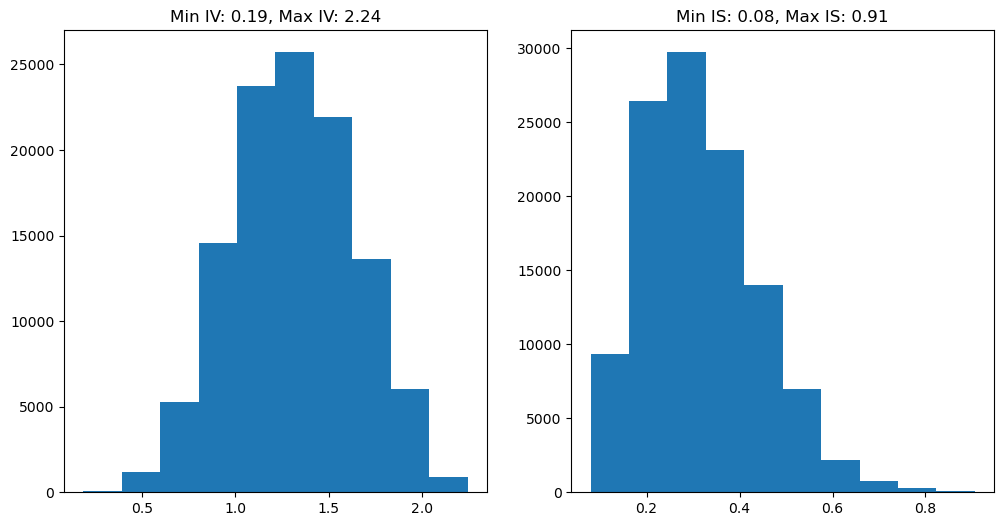

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  


ax[0].hist(calculated_features_df['IV_steps'])
ax[0].set_title(f'Min IV: {calculated_features_df['IV_steps'].min():.2f}, Max IV: {calculated_features_df['IV_steps'].max():.2f}');

ax[1].hist(calculated_features_df['IS_steps'])
ax[1].set_title(f'Min IS: {calculated_features_df['IS_steps'].min():.2f}, Max IS: {calculated_features_df['IS_steps'].max():.2f}');

In [63]:
# Export raw files for future use
print_calc_df = 1

if print_calc_df:

    all_hourly_data['report_date'] = pd.to_datetime(all_hourly_data['date']) # duplicate date to copy over during IV, IS
    grouped_data = all_hourly_data.sort_values(['subid','date']).reset_index(drop=True).groupby('subid')
     
    for id,group in grouped_data:
        group['report_date'] = pd.to_datetime(group['report_date'])
        df_per_id = pd.DataFrame(columns = group.columns).astype(group.dtypes)
        weekly_grouped = pd.merge(group, week_df[['date','week','year', 'hour']], how = 'left').groupby(['year','week'])
        
        for (year, week),week_group in weekly_grouped:
            
            dates_available = week_group.date.unique()
            if len(dates_available) > 0 and len(dates_available) < 3:
                week_group = week_group[~week_group.date.isin(dates_available)]
            else:
                subset = week_df.query(f"week == {week} and year == {year}")
                superset = pd.merge(subset, week_group, on = ['date','week', 'year', 'hour'], how = 'left', suffixes = ('', '_'))
                superset['subid'] = id
                df_per_id = pd.concat([df_per_id, superset]) # store all relevant weeks' per subject and export
        
        df_per_id.drop('report_date', axis =1).to_csv(cleaned_data_path + 'IV & IS steps/' + f'IV_IS steps - {id}.csv', index = False)

### Sleep std & coefficient of variation

We cannot compute IV and IS for sleep as we do not have hourly data for sleep, instead std and cov are opted for daily sleep data. Logic is similar to `Additional Features Calculation` script

- Create an interpolation df `week_df` of hourly granularity (24 hrs/entries for each day/date), ranging from the first and last dates from `all_hourly_data`
    - `week_df` contains dates ranging from 2017 to 2021
    - this df will also contain week numbers based on ISO calendar for consistency in week number allocations (leap year or otherwise)
      
- Group daily `sleep_data` by subid and iterate over each group  
    - For each group, retrieve week numbers from `week_df` based on date
    - Iterate over each week number (rows are already sorted by date) for the current subid
        - use `week_df` to interpolate any missing dates and/or hours as each day must have 24 hours i.e, 168 hours each week 
        - For the interpolated data points, use mean imputation
        - compute std and cov for each week
     
- There is an extra step at the beginning where the date field in `req_sleep_data` is duplicated (`report_date`). This is because we have additional dates to pad out missing dates for each week after interpolation
    - When we generate the weekly average data in `sleep_std_cov`, we simply duplicate the std and cov computations for all dates corresponding to that week
    - Using the `date` column would generate more duplicates resulting in computational overhead only to be dropped when merging with sleep data in subsequent steps
    - Or if we wanted to generate weekly average data, where we have only entry per week, the date used for this record would simply be the first date for that week. If this is an interpolated date i.e., from `week_df`, any subsequent merge operation would result in a lot of dropped records due to date mismatch as we would need to join on 'subid' and 'date'
    - Saving the original dates from the raw data (as `report_date`) mainly prevents loss of records during merge with chunked_df, sleep or demographic data 

In [64]:
sleep_cols = ['subid', 'date', 'duration_hrs', 'time_to_bed_2pi', 'wakeup_time_2pi']
req_sleep_data = sleep_data[sleep_cols]
req_sleep_data.loc[:,'report_date'] = req_sleep_data.loc[:,'date'] # dates needed to join w/ step data after interpolating missing dates
req_sleep_data

/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_38643/786844451.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req_sleep_data.loc[:,'report_date'] = req_sleep_data.loc[:,'date'] # dates needed to join w/ step data after interpolating missing dates


,subid,date,duration_hrs,time_to_bed_2pi,wakeup_time_2pi,report_date
0,1113,2018-06-29,6.966389,6.047566,1.583886,2018-06-29
1,1113,2018-06-30,8.049722,5.964663,1.784599,2018-06-30
2,1113,2018-07-01,6.666389,6.099926,1.557706,2018-07-01
3,1113,2018-07-02,8.116389,5.694137,1.531526,2018-07-02
4,1113,2018-07-03,6.449722,6.121742,1.522800,2018-07-03
...,...,...,...,...,...,...
85782,2266,2020-05-08,9.583056,5.759587,1.980949,2020-05-08
85783,2266,2020-05-09,8.983056,5.794493,1.858776,2020-05-09
85784,2266,2020-05-10,10.799444,5.297074,2.207842,2020-05-10
85785,2266,2020-05-11,5.949722,0.157080,1.710423,2020-05-11


In [65]:
# Generate week_df (identical to Additional Features Calculation)

all_hourly_data['date'] = pd.to_datetime(all_hourly_data['date']).apply(lambda x: x.date())

# Creating lookup table without the use of ISO calendar

start_date = all_hourly_data['date'].min() # date ranges for lookup table using first & last dates in hourly data
end_date = all_hourly_data['date'].max()

day_of_week = start_date.isocalendar() [2] # take ISO weekday from date
if day_of_week !=1: # if start date lies in the middle of the week, get the starting date (Monday) of that week number instead 
    start_date = start_date - timedelta(day_of_week - 1) # rewind number of days away from monday and extract date as start_date

day_of_week = end_date.isocalendar() [2] # take ISO weekday from date
if day_of_week !=1: # if end date lies in the middle of the week, get the starting date (Monday) of that week number instead 
    end_date = end_date - timedelta(day_of_week - 1) # rewind number of days away from monday and extract date as end_date

week_df = pd.DataFrame()

week_df['date'] = [i for i in pd.date_range(start_date, end_date).date for j in range(24)] # dates with 24 hour granularity
week_df['week'] = week_df['date'].apply(lambda x: x.isocalendar()[1]) # fetch weeknumber based on date
week_df['year'] = week_df['date'].apply(lambda x: x.year) # year column to avoid mismatch with week number lookup alone
week_df['hour'] = [j for i in range(len(week_df['date'])//24) for j in range(1,25)]
week_df['date'] = pd.to_datetime(week_df['date'])

In [66]:
sub_grouped = req_sleep_data.sort_values(['subid','date']).groupby('subid')

sleep_std_cov = []

for id,group in sub_grouped:
    
    weekly_grouped = pd.merge(group, week_df[['date', 'week', 'year']].drop_duplicates(),on= 'date').groupby(['year','week'])
    
    for (year, week),week_group in weekly_grouped:
    
        subset = week_df.query(f"week == {week} and year == {year}")
        superset = pd.merge(subset, week_group, on = ['date','week', 'year'], how = 'left', suffixes = ('', '_'))
        superset['subid'] = id
        mean_sleep = superset['duration_hrs'].mean()
        superset['duration_hrs'] = superset['duration_hrs'].fillna(mean_sleep) 
        superset.date = pd.to_datetime(superset.date)
        
        weeks_years_all = superset[['week', 'year']].drop_duplicates().sort_values('year').to_records(index= False)


        for (week, year) in weeks_years_all:
            seven_days = superset.query(f'week == {week} & year == {year}')
    
            std_per_week = seven_days['duration_hrs'].std()
            mean_per_week = seven_days['duration_hrs'].mean()
            cov_per_week = std_per_week/ mean_per_week
    
            dates_from_sleep_df = seven_days['report_date'].dropna().unique() 


            for date in dates_from_sleep_df:
            
                # Append calculated features to list using originally available dates in sleep_df to prevent record drop when merging w/ step
                sleep_std_cov.append({'subid': id, 'report_date': date.date(),
                                     'duration_hrs_w_std': std_per_week, 
                                     'duration_hrs_w_cov': cov_per_week })


In [67]:
sleep_std_cov_df = pd.DataFrame(sleep_std_cov)
sleep_std_cov_df['report_date'] = pd.to_datetime(sleep_std_cov_df['report_date'])
sleep_std_cov = pd.merge(sleep_std_cov_df, req_sleep_data, on = ['subid','report_date']).drop('report_date', axis = 1)

In [68]:
print_cov = 1 # export sleep std & cov w/o interpolating sleep duration

if print_cov:
    sub_grouped = req_sleep_data.sort_values(['subid','date']).groupby('subid')

    sleep_std_cov = []
    
    for id,group in sub_grouped:
        
        weekly_grouped = pd.merge(group, week_df[['date', 'week', 'year']].drop_duplicates(),on= 'date').groupby(['year','week'])
        
        for (year, week),week_group in weekly_grouped:
        
            subset = week_df.query(f"week == {week} and year == {year}")
            superset = pd.merge(subset, week_group, on = ['date','week', 'year'], how = 'left', suffixes = ('', '_'))
            superset['subid'] = id
            superset.date = pd.to_datetime(superset.date)
            
            weeks_years_all = superset[['week', 'year']].drop_duplicates().sort_values('year').to_records(index= False)
    
    
            for (week, year) in weeks_years_all:
                seven_days = superset.query(f'week == {week} & year == {year}')
        
                std_per_week = seven_days['duration_hrs'].std()
                mean_per_week = seven_days['duration_hrs'].mean()
                cov_per_week = std_per_week/ mean_per_week
        
                dates_from_sleep_df = seven_days['report_date'].dropna().unique() 
    
    
                for date in dates_from_sleep_df:
                
                    # Append calculated features to list using originally available dates in sleep_df to prevent record drop when merging w/ step
                    sleep_std_cov.append({'subid': id, 'report_date': date.date(), 
                                         'duration_hrs_w_std': std_per_week, 
                                         'duration_hrs_w_cov': cov_per_week })

    sleep_std_cov_df = pd.DataFrame(sleep_std_cov)
    sleep_std_cov_df['report_date'] = pd.to_datetime(sleep_std_cov_df['report_date'])
    sleep_std_cov = pd.merge(sleep_std_cov_df, req_sleep_data, on = ['subid','report_date']).drop('report_date', axis = 1)
    sleep_std_cov.to_csv(cleaned_data_path + 'sleep_weekly_std_cov.csv', index = False)

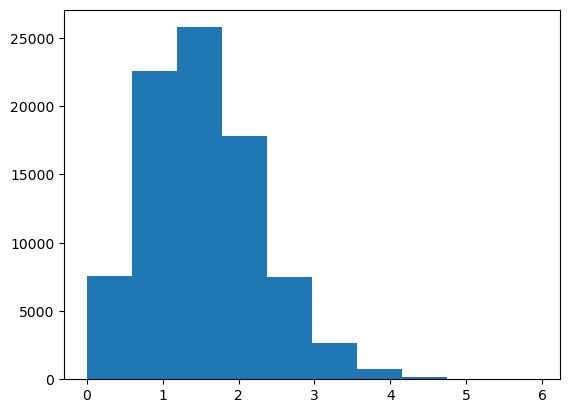

In [69]:
plt.hist(sleep_std_cov_df['duration_hrs_w_std']);

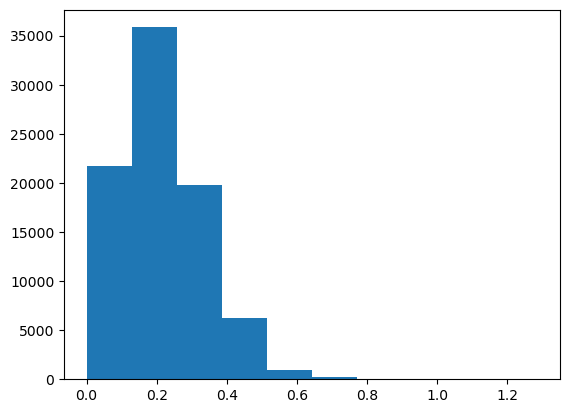

In [70]:
plt.hist(sleep_std_cov_df['duration_hrs_w_cov']);

## Predictions

Combine step, sleep and demographic data.

- Read file `step_data.csv` if `step_data` is not initialized
- Read file `demo_265.csv` if `demo` is not initialized
- Read file `sleep_weekly_std_cov.csv` if not initiliazed
- Merge step & demo, and then w/ sleep

In [71]:
step_data = pd.read_csv(cleaned_data_path + 'step_data.csv')

In [72]:
demo = pd.read_csv(cleaned_data_path + 'demo_265.csv')

In [73]:
sleep_std_cov = pd.read_csv(cleaned_data_path + 'sleep_weekly_std_cov.csv')

In [74]:
step_demo = pd.merge(step_data[step_df.columns], demo.dropna(subset = ['age','gender'])[['subid', 'age','gender','mci']],  on='subid', how = 'left')
step_demo.drop(['first', 'last'], axis =1, inplace = True)
step_demo = step_demo.bfill().ffill() # age & gender

step_sleep_demo = pd.merge(step_demo, sleep_std_cov,  on=['subid','date'], how = 'inner')
step_sleep_demo['date'] = pd.to_datetime(step_sleep_demo['date'])

### Merge w/ chunked_df and calculated_features_df

- Read `chunked_step_counts.csv` if `chunked_df` is not initialized
- Read `calc_features.csv` if 'calculated_features_df` is not initialized

In [75]:
chunked_df = pd.read_csv(dir_2b_path + 'chunked_step_counts.csv')

In [76]:
calculated_features_df = pd.read_csv(dir_2b_path + 'calc_features.csv')

In [77]:
chunked_df['date'] = pd.to_datetime(chunked_df['date'])
calculated_features_df['report_date'] = pd.to_datetime(calculated_features_df['report_date'])

step_sleep_all = pd.merge(step_sleep_demo, chunked_df, on=['subid','date'], how = 'left')
step_sleep_calc = pd.merge(step_sleep_all, calculated_features_df, left_on=['subid','date'],right_on=['subid','report_date'], how = 'left').drop('report_date', axis=1).reset_index(drop=True)
step_sleep_calc

,subid,homeid,study,date,steps,age,gender,mci,duration_hrs_w_std,duration_hrs_w_cov,...,midnight_steps,morning_steps,afternoon_steps,evening_steps,IV_steps,IS_steps,Acro_steps,Nadir_steps,Amp_steps,Total_steps
0,1113,1135,OHSU-CART,2018-06-29,384,87.800000,2.0,0.0,0.598328,0.082785,...,0,0,245,139,0.929108,0.137394,73.220126,2.981707,70.238418,503.571429
1,1113,1135,OHSU-CART,2018-06-29,384,88.900000,2.0,0.0,0.598328,0.082785,...,0,0,245,139,0.929108,0.137394,73.220126,2.981707,70.238418,503.571429
2,1113,1135,OHSU-CART,2018-06-30,855,87.800000,2.0,0.0,0.598328,0.082785,...,0,437,182,236,0.929108,0.137394,73.220126,2.981707,70.238418,503.571429
3,1113,1135,OHSU-CART,2018-06-30,855,88.900000,2.0,0.0,0.598328,0.082785,...,0,437,182,236,0.929108,0.137394,73.220126,2.981707,70.238418,503.571429
4,1113,1135,OHSU-CART,2018-07-01,2286,87.800000,2.0,0.0,0.598328,0.082785,...,0,1363,420,503,0.929108,0.137394,73.220126,2.981707,70.238418,503.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125607,2266,1969,RUSH-CART,2020-05-08,5430,86.078029,2.0,1.0,0.850598,0.089737,...,0,3816,1327,287,1.247217,0.163606,536.251572,2.414634,533.836938,2193.857143
125608,2266,1969,RUSH-CART,2020-05-09,2849,86.078029,2.0,1.0,0.850598,0.089737,...,0,352,2283,214,1.247217,0.163606,536.251572,2.414634,533.836938,2193.857143
125609,2266,1969,RUSH-CART,2020-05-10,930,86.078029,2.0,1.0,0.850598,0.089737,...,0,527,384,19,1.247217,0.163606,536.251572,2.414634,533.836938,2193.857143
125610,2266,1969,RUSH-CART,2020-05-11,3182,86.078029,2.0,1.0,0.269489,0.047420,...,0,1888,982,312,1.305841,0.126823,246.742138,1.426829,245.315309,1027.000000


### Some participants have varying MCI status for each annual checkup

- Since we have multiple demographic records for each participant, this means we have multiple report dates for each participant.  
- Some participants may have tested positive for MCI during their first checkup and negative during the next and vice versa
- To resolve ambiguity regarding MCI status, force MCI status from first report date for each participant for all data points

In [78]:
grouped = step_sleep_calc.groupby('subid')

# Set the first MCI value for each subject directly in the 'MCI' column
step_sleep_calc['mci'] = grouped['mci'].transform('first') # update MCI status based on first 
[subject for subject, group_data in grouped if len(group_data['mci'].unique()) > 1] # list will be empty if fixed 


[]

### Transform the data if necessary

- It might be necessary to apply log, sqrt or other transformations to certain skewed features and perform t-test to compare any notable differences.
- Create additional columns (if needed) to store transformed features
- This is final stage before classification, hence more features may be included, such as 'mean' and 'std' for certain step & sleep features

In [79]:
try:
    transform_data
except NameError:
    print('"transform_data" and/or "transform" is not defined.\nPlease set "transform_data" and "transform" appropriately in "Additional features Calculation" section and execute all subsequent cells for changes to take effect')
else:
    print(f'transform_data is set to {transform_data} and transform used is {transform}.\nPlease change if desired before proceeding with the t-test')
    

transform_data is set to 0 and transform used is log.
Please change if desired before proceeding with the t-test


In [80]:
if not transform_data: # no transformation required

    # features for which 'std' must be calculated
    mean_std_features = ['subid', f'time_to_bed_2pi', f'wakeup_time_2pi', 'Total_steps', f'morning_steps', f'afternoon_steps', f'evening_steps', f'midnight_steps'] 

    # columns used for t-test; date is needed for next step
    t_test_cols = ['subid', 'age', 'gender', 'date', 'mci',
     'duration_hrs', 'duration_hrs_w_std', 'duration_hrs_w_cov',
     'Total_steps', f'morning_steps',  f'afternoon_steps',  f'evening_steps', f'midnight_steps',
     'Acro_steps', 'Amp_steps', 'IS_steps', 'IV_steps', 'Nadir_steps',
     'time_to_bed_2pi',  'wakeup_time_2pi',
     'time_to_bed_2pi_std', 'wakeup_time_2pi_std',
    f'Total_steps_std',  f'morning_steps_std', f'afternoon_steps_std',  f'evening_steps_std', f'midnight_steps_std']

else: # transformation is required
    
    prefix = transform # copy name of transformation to create new columns 

    # features for which 'std' must be calculated
    mean_std_features = ['subid', f'time_to_bed_2pi', f'wakeup_time_2pi', 'Total_steps', f'{prefix}_morning_steps', f'{prefix}_afternoon_steps', f'{prefix}_evening_steps', f'{prefix}_midnight_steps'] 

    # columns used for t-test; date is needed for next step
    t_test_cols = ['subid', 'age', 'gender', 'date', 'mci',
     'duration_hrs', 'duration_hrs_w_std', 'duration_hrs_w_cov',
     'Total_steps', f'{prefix}_morning_steps',  f'{prefix}_afternoon_steps',  f'{prefix}_evening_steps', f'{prefix}_midnight_steps',
     'Acro_steps', 'Amp_steps', 'IS_steps', 'IV_steps', 'Nadir_steps',
     'time_to_bed_2pi',  'wakeup_time_2pi',
     'time_to_bed_2pi_std', 'wakeup_time_2pi_std',
    f'{prefix}_steps_std',  f'{prefix}_morning_steps_std', f'{prefix}_afternoon_steps_std',  f'{prefix}_evening_steps_std', f'{prefix}_midnight_steps_std']

    # Transform the features
    
    if prefix == 'log':
        
        delta = math.e
        step_sleep_calc.loc[:,f'{prefix}_Total_steps'] = step_sleep_calc.loc[:,'Total_steps'].apply(lambda x: math.log(x) if x!=0 else math.log(delta))
        step_sleep_calc.loc[:,f'{prefix}_morning_steps'] = step_sleep_calc.loc[:,'morning_steps'].apply(lambda x: math.log(x) if x!=0 else math.log(delta))
        step_sleep_calc.loc[:,f'{prefix}_afternoon_steps'] = step_sleep_calc.loc[:,'afternoon_steps'].apply(lambda x: math.log(x) if x!=0 else math.log(delta))
        step_sleep_calc.loc[:,f'{prefix}_evening_steps'] = step_sleep_calc.loc[:,'evening_steps'].apply(lambda x: math.log(x) if x!=0 else math.log(delta))
        step_sleep_calc.loc[:,f'{prefix}_midnight_steps'] = step_sleep_calc.loc[:,'midnight_steps'].apply(lambda x: math.log(x) if x!=0 else math.log(delta))
        
    elif prefix == 'sqrt':
        
        step_sleep_calc.loc[:,f'{prefix}_Total_steps'] = step_sleep_calc.loc[:,'Total_steps'].apply(lambda x: np.sqrt(x) if x!=0 else np.nan)
        step_sleep_calc.loc[:,f'{prefix}_morning_steps'] = step_sleep_calc.loc[:,'morning_steps'].apply(lambda x: np.sqrt(x) if x!=0 else np.nan)
        step_sleep_calc.loc[:,f'{prefix}_afternoon_steps'] = step_sleep_calc.loc[:,'afternoon_steps'].apply(lambda x: np.sqrt(x) if x!=0 else np.nan)
        step_sleep_calc.loc[:,f'{prefix}_evening_steps'] = step_sleep_calc.loc[:,'evening_steps'].apply(lambda x: np.sqrt(x) if x!=0 else np.nan)
        step_sleep_calc.loc[:,f'{prefix}_midnight_steps'] = step_sleep_calc.loc[:,'midnight_steps'].apply(lambda x: np.sqrt(x) if x!=0 else np.nan)


    elif prefix == 'cbrt':
        
        step_sleep_calc.loc[:,f'{prefix}_Total_steps'] = step_sleep_calc.loc[:,'Total_steps'].apply(lambda x: np.cbrt(x) if x!=0 else np.nan)
        step_sleep_calc.loc[:,f'{prefix}_morning_steps'] = step_sleep_calc.loc[:,'morning_steps'].apply(lambda x: np.cbrt(x) if x!=0 else np.nan)
        step_sleep_calc.loc[:,f'{prefix}_afternoon_steps'] = step_sleep_calc.loc[:,'afternoon_steps'].apply(lambda x: np.cbrt(x) if x!=0 else np.nan)
        step_sleep_calc.loc[:,f'{prefix}_evening_steps'] = step_sleep_calc.loc[:,'evening_steps'].apply(lambda x: np.cbrt(x) if x!=0 else np.nan)
        step_sleep_calc.loc[:,f'{prefix}_midnight_steps'] = step_sleep_calc.loc[:,'midnight_steps'].apply(lambda x: np.cbrt(x) if x!=0 else np.nan)





#### Histograms of original vs. transformed features

In [81]:
if transform_data: # if transformation has been performed
    
    fig, ax =plt.subplots(1,2, figsize = (18, 6))
    k = ceil(1+log(len(step_sleep_calc), 2))
    
    step_sleep_calc['Total_steps'].hist(bins =k, ax = ax[0])
    ax[0].set_title(f'Steps before {prefix} transform')
    step_sleep_calc[f'{prefix}_Total_steps'].hist( bins =k, ax = ax[1])
    ax[1].set_title(f'Steps after {prefix} transform');

In [82]:
if transform_data: # if transformation has been performed
    fig, ax =plt.subplots(1,2, figsize = (18, 6))
    k = ceil(1+log(len(step_sleep_calc), 2))
    
    step_sleep_calc['morning_steps'].hist(bins =k, ax = ax[0])
    ax[0].set_title(f'Morning Steps before {prefix} transform')
    step_sleep_calc[f'{prefix}_morning_steps'].hist( bins =k, ax = ax[1])
    ax[1].set_title(f'Morning Steps after {prefix} transform');

In [83]:
if transform_data: # if transformation has been performed
    fig, ax =plt.subplots(1,2, figsize = (18, 6))
    k = ceil(1+log(len(step_sleep_calc), 2))
    
    step_sleep_calc['afternoon_steps'].hist(bins =k, ax = ax[0])
    ax[0].set_title(f'afternoon Steps before {prefix} transform')
    step_sleep_calc[f'{prefix}_afternoon_steps'].hist( bins =k, ax = ax[1])
    ax[1].set_title(f'afternoon Steps after {prefix} transform');

In [84]:
if transform_data: # if transformation has been performed
    fig, ax =plt.subplots(1,2, figsize = (18, 6))
    k = ceil(1+log(len(step_sleep_calc), 2))
    
    step_sleep_calc['evening_steps'].hist(bins =k, ax = ax[0])
    ax[0].set_title(f'evening Steps before {prefix} transform')
    step_sleep_calc[f'{prefix}_evening_steps'].hist( bins =k, ax = ax[1])
    ax[1].set_title(f'evening Steps after {prefix} transform');

In [85]:
if transform_data: # if transformation has been performed
    fig, ax =plt.subplots(1,2, figsize = (18, 6))
    k = ceil(1+log(len(step_sleep_calc), 2))
    
    step_sleep_calc['midnight_steps'].hist(bins =k, ax = ax[0])
    ax[0].set_title(f'midnight Steps before {prefix} transform')
    step_sleep_calc[f'{prefix}_midnight_steps'].hist( bins =k, ax = ax[1])
    ax[1].set_title(f'midnight Steps after {prefix} transform');

In [86]:
if transform_data: # if transformation has been performed
    fig, ax =plt.subplots(1,2, figsize = (18, 6))
    k = ceil(1+log(len(step_sleep_calc), 2))
    
    step_sleep_calc['time_to_bed_2pi'].hist(bins =k, ax = ax[0])
    ax[0].set_title(f'Time to bed before {prefix} transform')
    step_sleep_calc[f'{prefix}_time_to_bed_2pi'].hist( bins =k, ax = ax[1])
    ax[1].set_title(f'Time to bed  after {prefix} transform');

In [87]:
if transform_data: # if transformation has been performed
    fig, ax =plt.subplots(1,2, figsize = (18, 6))
    k = ceil(1+log(len(step_sleep_calc), 2))
    
    step_sleep_calc['wakeup_time_2pi'].hist(bins =k, ax = ax[0])
    ax[0].set_title(f'Wake up time before {prefix} transform')
    step_sleep_calc[f'{prefix}_wakeup_time_2pi'].hist( bins =k, ax = ax[1])
    ax[1].set_title(f'Wake up time  after {prefix} transform');

### T-test

T-test is performed to determine if there any features that can significantly contribute to group differences.  
The two tailed test uses 1 week of participant data 

We use the `transform` flag set in `Additional features Calculation` script to determine, how to handle preprocessing for t-test

In [88]:
# group data by subid to calculate 'mean' and 'std'
grouped_stats = step_sleep_calc[mean_std_features].groupby('subid').agg(['std'])

# convert multi index column, e.g., Total_steps -> mean & Total_steps -> std as Total_steps_mean & Total_steps_std
grouped_stats.columns = ['_'.join(col).strip() for col in grouped_stats.columns.values] 

# merge the new features with step-sleep-demo df
final_df_std = pd.merge(step_sleep_calc, grouped_stats, left_on='subid', right_index= True)#, suffixes=('', '_stats'))

# select only desired columns for t-test
final_df_ttest = final_df_std[t_test_cols] 
final_df_ttest.rename(columns={'date':'report_date'}, inplace = True)
final_df_ttest =final_df_ttest.bfill().ffill()


/var/folders/rj/zwtj8c7j7_dfq7hhfxsytydm0000gn/T/ipykernel_38643/1704155790.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_ttest.rename(columns={'date':'report_date'}, inplace = True)


In [89]:
final_df_ttest['report_date'] = pd.to_datetime(final_df_ttest['report_date'])
first_week_df = avg_desired_weeks(final_df_ttest,7) # find average of first week of data before performing t-test

mci_group = first_week_df[first_week_df['mci'] == 1].drop(['subid','mci'],axis=1)
normal_group = first_week_df[first_week_df['mci'] == 0].drop(['subid','mci'],axis=1)

res = ttest_ind(normal_group, mci_group, random_state=44,axis=0)
significances = [1 if p_value < 0.05 else 0 for p_value in res.pvalue]

tstat_df = pd.DataFrame(zip(res.statistic, res.pvalue,significances),index = mci_group.columns.values, columns = [f't-statistic ({res.df[0]})','p-value','Statistically Significant'] )
print(f"Count of features w/ significance: {Counter(tstat_df['Statistically Significant'])}")
tstat_df.sort_values(['Statistically Significant',f't-statistic ({res.df[0]})'], ascending = False) 



Count of features w/ significance: Counter({0: 22, 1: 2})


,t-statistic (260.0),p-value,Statistically Significant
midnight_steps,-2.050056,0.041362,1
time_to_bed_2pi,-2.102085,0.036508,1
duration_hrs_w_std,1.767221,0.078364,0
gender,1.540807,0.124580,0
wakeup_time_2pi_std,1.420450,0.156675,0
wakeup_time_2pi,1.360188,0.174949,0
time_to_bed_2pi_std,1.102695,0.271179,0
duration_hrs_w_cov,1.011250,0.312837,0
evening_steps_std,0.855075,0.393297,0
IV_steps,0.616941,0.537813,0


#### Use the results from the t-test to influence feature set

- Only consider features whose p-value < 1 to trim feature set and prep for classifier
- Either aggregate all the data per subid so that there is only 1 row per subid
- Or consider time spans (few weeks or months) for each participant without any aggregation and classify

In [90]:
classifier_cols = ['subid', 'mci'] + tstat_df.query('`p-value`<1').index.to_list()  

# prep for classifier
classifier_df = pd.merge(step_sleep_calc, grouped_stats, left_on='subid', right_index= True)

# use below if all data must be aggregated to row per subid
# classifier_df = classifier_df[classifier_cols]
# std_features = ['subid'] + classifier_df.columns[classifier_df.columns.str.endswith('std')].tolist()
# classifier_df_std = classifier_df[std_features].drop_duplicates('subid').reset_index() # average per subid, to be merged after remaining data is averaged per subid
# features_to_avg = ['subid'] + classifier_df.columns.difference(std_features).tolist() # remaining features & subid
# classifier_df_avg = classifier_df[features_to_avg].groupby('subid').agg('mean').reset_index()

# final_df = pd.merge(classifier_df_avg, classifier_df_std, on = 'subid')
# final_df = final_df.bfill().ffill() 


In [91]:
# group data by subid
sub_group = classifier_df.groupby('subid')

time_range_df = pd.DataFrame()

for id, group in sub_group:
    group = group.sort_values('date')
    group = group.drop_duplicates('date')
    first_date = group.date.min()
    last_date = first_date + timedelta(days = 30) # consider upto 6 months of each participants data; change as desired

    group_shortened = group.loc[group.date<=last_date] # apply date filter from previous step
    time_range_df = pd.concat([time_range_df, group_shortened]) # concatenate rows for each subject

final_df = time_range_df[classifier_cols]
final_df = final_df.bfill().ffill()

final_df.columns

Index(['subid', 'mci', 'age', 'gender', 'duration_hrs', 'duration_hrs_w_std',
       'duration_hrs_w_cov', 'Total_steps', 'morning_steps', 'afternoon_steps',
       'evening_steps', 'midnight_steps', 'Acro_steps', 'Amp_steps',
       'IS_steps', 'IV_steps', 'Nadir_steps', 'time_to_bed_2pi',
       'wakeup_time_2pi', 'time_to_bed_2pi_std', 'wakeup_time_2pi_std',
       'Total_steps_std', 'morning_steps_std', 'afternoon_steps_std',
       'evening_steps_std', 'midnight_steps_std'],
      dtype='object')

### Exclude_17 integration and export

- Read `exclude_17.csv` which is the cumulative output of `DemoClean.py` and `ProcessSensor.py` script from the weekly data notebook
- Merge chunked step counts and 
- Merge weekly step, sleep and step & sleep data with `exclude_17` and export
- Repeat for daily step and sleep


In [110]:
exclude_17 = pd.read_csv(mobility_path + 'exclude_17.csv')

In [112]:

exclude_17['report_date'] = pd.to_datetime(exclude_17['report_date'])
chunked_df['date'] = pd.to_datetime(chunked_df['date'])
step_df['date'] = pd.to_datetime(step_df['date'], format = 'mixed')
sleep_df['date'] = pd.to_datetime(sleep_df['date'])
watch_sleep_weekly_df['date'] = pd.to_datetime(watch_sleep_weekly_df['date'])

# Hourly 
#Step count chunked

chunked_steps_excl_17 = pd.merge(exclude_17,chunked_df, right_on = ['subid','date'],left_on = ['subid','report_date'], how = 'right')
chunked_steps_excl_17.to_csv(cleaned_data_path + 'chunked_steps_excl_17.csv', index = False)

# IV, IS steps - for previously used weekly data (OLD logic for IV, IS nadir acro)
calculated_features_excl_17 = pd.merge(exclude_17,calculated_features_df, on = ['subid','report_date'], how = 'right')
calculated_features_excl_17.to_csv(cleaned_data_path + 'calculated_features_excl_17.csv', index = False)

    
# Daily steps
update_dtypes(step_df, ['date'], 'datetime64[ns]')
daily_step_excl_17 = pd.merge(exclude_17.drop(['homeid', 'study'],axis = 1), step_df, right_on = ['subid','date'],left_on = ['subid','report_date'], how = 'right')
daily_step_excl_17.to_csv(cleaned_data_path + 'daily_step_excl_17.csv', index = False)

# Daily sleep
update_dtypes(sleep_df, ['date'], 'datetime64[ns]')
daily_sleep_excl_17 = pd.merge( exclude_17.drop(['homeid', 'study'],axis = 1), sleep_df, right_on = ['subid','date'],left_on = ['subid','report_date'], how = 'right')
daily_sleep_excl_17.to_csv(cleaned_data_path + 'daily_sleep_excl_17.csv', index = False)

# Daily step, sleep 
daily_step_excl_17 = pd.merge(exclude_17.drop(['homeid', 'study'],axis = 1),step_df, right_on = ['subid','date'],left_on = ['subid','report_date'], how = 'right')
daily_step_sleep_excl_17 = pd.merge(daily_step_excl_17, sleep_df.drop(['homeid', 'study'],axis = 1), left_on = ['subid','date'],right_on = ['subid','date'], how = 'left') # step has more data than sleep
daily_step_sleep_excl_17.to_csv(cleaned_data_path + 'daily_step_sleep_excl_17.csv', index = False)

# Weekly step data
weekly_step_excl_17 = pd.merge(exclude_17,watch_step_weekly_df, right_on = ['subid','date'],left_on = ['subid','report_date'], how = 'right')
weekly_step_excl_17.to_csv(cleaned_data_path + 'weekly_step_excl_17.csv', index = False)

# Weekly sleep data
weekly_sleep_excl_17 = pd.merge(exclude_17,watch_sleep_weekly_df, right_on = ['subid','date'],left_on = ['subid','report_date'], how = 'right')
weekly_sleep_excl_17.to_csv(cleaned_data_path + 'weekly_sleep_excl_17.csv', index = False)

# Weekly step, sleep data 
weekly_step_sleep_excl_17 = pd.merge(weekly_step_excl_17, watch_sleep_weekly_df, on = ['subid','date'], how = 'left')
weekly_step_sleep_excl_17.to_csv(cleaned_data_path + 'weekly_step_sleep_excl_17.csv', index = False)

In [113]:
# Use updated sleep calculations and filters such as duration_hrs <=15 & time to bed & wake up as local time

sleep_cols = sleep_df.columns.to_list() + ['time_to_bed_2pi', 'wakeup_time_2pi']
sleep_data[sleep_cols]

step_data[step_df.columns]

update_dtypes(step_df, ['date'], 'datetime64[ns]')
step_data['date'] = pd.to_datetime(step_data['date'])
exclude_17['report_date'] = pd.to_datetime(exclude_17['report_date'])
                                           
daily_step_excl_17 = pd.merge(exclude_17.drop(['homeid', 'study'],axis = 1), step_data[step_df.columns], right_on = ['subid','date'],left_on = ['subid','report_date'], how = 'right')
daily_step_excl_17.to_csv(cleaned_data_path + 'daily_step_excl_17.csv', index = False)

# Daily sleep
update_dtypes(sleep_data, ['date'], 'datetime64[ns]')
daily_sleep_excl_17 = pd.merge( exclude_17.drop(['homeid', 'study'],axis = 1), sleep_data[sleep_cols], right_on = ['subid','date'],left_on = ['subid','report_date'], how = 'right')
daily_sleep_excl_17.to_csv(cleaned_data_path + 'daily_sleep_excl_17.csv', index = False)

# Daily step, sleep 
daily_step_excl_17 = pd.merge(exclude_17.drop(['homeid', 'study'],axis = 1),step_data[step_df.columns], right_on = ['subid','date'],left_on = ['subid','report_date'], how = 'right')
daily_step_sleep_excl_17 = pd.merge(daily_step_excl_17, sleep_data[sleep_cols].drop(['homeid', 'study'],axis = 1), left_on = ['subid','date'],right_on = ['subid','date'], how = 'left') # step has more data than sleep
daily_step_sleep_excl_17.to_csv(cleaned_data_path + 'daily_step_sleep_excl_17.csv', index = False)


## Predictions

- For training, the subids is split 70/30 between training and testing as there is more than 1 record per subject
    - This is achieved by splitting subids for each class, MCI and normal cognition, for train and test sets for consistency in split
- Splitting records directly would result in a double dipping effect and muddle results as the records for the same participant could appear in training and test sets
- Once subids are split, we must account for variation in number of data points for each participant.
    - This is achieved by computing the ratio of records between train and test set with both classes combined
    - If the ratio lies between 60/40 and 80/20, training and classification is allowed
- To assess feature importance for each classifier, SHAP analysis can be performed by enabling the `shap_flag` in each model training cell. It is disabled by default
- For benchmark, we only use age & gender as the features and any duplicates are excluded (1 record per subject)

### Benchmark (age & gender)

In [92]:
shap_flag = 0 # set to 1 if SHAP analyses is required

n_iter = 100 # num of iterations
test_size = 0.3
num_of_classifiers = 5

# Initialize lists to store evaluation metrics for each model
dt_accuracy, svm_accuracy, rf_accuracy, lr_accuracy, xgb_accuracy= [[] for _ in range(num_of_classifiers)]
dt_precision, svm_precision, rf_precision, lr_precision, xgb_precision = [[] for _ in range(num_of_classifiers)]
dt_recall, svm_recall, rf_recall, lr_recall, xgb_recall = [[] for _ in range(num_of_classifiers)]
dt_f1, svm_f1, rf_f1, lr_f1,xgb_f1  =  [[] for _ in range(num_of_classifiers)]
dt_auc, svm_auc, rf_auc, lr_auc, xgb_auc = [[] for _ in range(num_of_classifiers)]
all_dt_shap_values,all_svm_shap_values, all_rf_shap_values, all_lr_shap_values, all_xgb_shap_values  =  [[] for _ in range(num_of_classifiers)]
all_dt_shap_values_padded, all_svm_shap_values_padded, all_rf_shap_values_padded, all_lr_shap_values_padded, all_xgb_shap_values_padded =  [[] for _ in range(num_of_classifiers)]

# Split into X,y
X = final_df[['subid', 'age','gender', 'mci']].drop_duplicates(subset = 'subid', keep = 'first').drop(['subid','mci'], axis =1)
y = final_df[['subid', 'age','gender', 'mci']].drop_duplicates(subset = 'subid', keep = 'first')['mci']

skip_counter = 0 # keeps track of skipped iterations if the # of records in test set are not within expected range
fig_size  = (25, 18) 

for i in range(n_iter):
    
    if i == 99 and skip_counter>0:
        print(f'# of iterations skipped: {skip_counter}')
        i -= skip_counter
        skip_counter = 0 
        
    normal_subids = final_df.loc[final_df['mci']==0,'subid'].unique()
    mci_subids = final_df.loc[final_df['mci']==1,'subid'].unique()
    np.random.shuffle(normal_subids)
    np.random.shuffle(mci_subids)
    
    #split unique subids into train and test sets
    train_subids_n, test_subids_n = train_test_split(normal_subids, test_size = test_size, shuffle = True, random_state = i)
    train_subids_m, test_subids_m = train_test_split(mci_subids, test_size = test_size, shuffle = True, random_state = i)

    train_subids = np.append(train_subids_n, train_subids_m)
    test_subids = np.append(test_subids_n, test_subids_m)
    
    #Use train and test_subids to filter original dataframe
    train_data = final_df.loc[final_df['subid'].isin(train_subids), ['subid', 'age','gender', 'mci']]
    test_data = final_df.loc[final_df['subid'].isin(test_subids),  ['subid', 'age','gender', 'mci']]

    ratio = len(train_data) / len(test_data)

    
    # Check if the ratio is within the desired range
    if ratio < 1.5 or ratio > 4: 
        skip_counter += 1
        continue

    else:
        
        X_train, y_train = train_data.drop('mci', axis=1), train_data['mci']
        X_test, y_test = test_data.drop('mci',axis=1), test_data['mci']

        # print(np.sort(test_subids_m)) # to check if test subids are unique()
        
         # Reshape the target variable y_train
        y_train = np.ravel(y_train)
        
        # Reshape the target variable y_test
        y_test = np.ravel(y_test)
        
        X_train_imputed_df = X_train.reset_index(drop=True).iloc[:,1:] # drop subid
        X_test_imputed_df = X_test.reset_index(drop=True).iloc[:,1:] 
        
        int_cols = X_train_imputed_df.columns[X_train_imputed_df.dtypes == 'int64'] 
        cat_cols = ['gender'] 
        
        # update_dtypes(X_train_imputed_df, int_cols, 'int64')
        # update_dtypes(X_train_imputed_df, cat_cols, 'category')
        
        # update_dtypes(X_test_imputed_df, int_cols, 'int64')
        # update_dtypes(X_test_imputed_df, cat_cols, 'category')
        
        encode_cols = [] # Columns to be one-hot encoded 

        X_train_final = preprocessing(X_train_imputed_df, encode_cols);
        X_test_final = preprocessing(X_test_imputed_df, encode_cols);
        
        # # After encoding, scarce categorical values might exist in training or testing sets alone. Fix mismatch
        # # Start by finding the column(s) missing
        test_only = list(set(X_test_final.columns) - set(X_train_final.columns))
        train_only = list(set(X_train_final.columns) - set(X_test_final.columns))    
        
        if train_only: # for encoded columns that exist in training set alone replicate in test
        
            for col in train_only:
                X_test_final[col] = 0
                copy_type = type(X_train_final.loc[0,col])
                X_test_final[col] = X_test_final[col].astype(copy_type)  # align dtypes
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        
        elif test_only: # repeat for one-hot encoded columns exclusive to test 
        
            for col in train_only:
                X_train_final[col] = 0
                copy_type = type(X_test_final.loc[0,col])
                X_train_final[col] = X_train_final[col].astype(copy_type)
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        # X_train_final = study_trend_and_add_features(X_train_final)
        # X_test_final = study_trend_and_add_features(X_test_final)
        
        # Initialize classifiers
        decision_tree = DecisionTreeClassifier( random_state=i)
        svm = SVC(C=0.1, kernel='linear', gamma =1,  random_state=i)
        random_forest = RandomForestClassifier(random_state=i)
        LR = LogisticRegression(solver='liblinear',random_state=i, max_iter = 3000, C=100, penalty = 'l2')
        #     LR = LogisticRegression(C=100, max_iter=3000, random_state=i,solver='newton-cholesky')
        xgb = XGBClassifier(random_state = i, enable_categorical=True)
        
        #Train classifiers on training data
        decision_tree.fit(X_train_final, y_train)
        svm.fit(X_train_final, y_train)
        random_forest.fit(X_train_final, y_train)
        LR.fit(X_train_final, y_train)
        xgb.fit(X_train_final, y_train)
        
        # Make predictions on the testing data
        dt_pred = decision_tree.predict(X_test_final)
        svm_pred = svm.predict(X_test_final)
        rf_pred = random_forest.predict(X_test_final)
        lr_pred = LR.predict(X_test_final)
        xgb_pred = xgb.predict(X_test_final)
        
        #calculate accuracy, precision, recall, f1 and store in list
        dt_accuracy.append(accuracy_score(y_test, dt_pred))
        svm_accuracy.append(accuracy_score(y_test, svm_pred))
        rf_accuracy.append(accuracy_score(y_test, rf_pred))
        lr_accuracy.append(accuracy_score(y_test, lr_pred))
        xgb_accuracy.append(accuracy_score(y_test, xgb_pred))
        
        dt_precision.append(precision_score(y_test, dt_pred,zero_division =0))
        svm_precision.append(precision_score(y_test, svm_pred,zero_division = 0))
        rf_precision.append(precision_score(y_test, rf_pred,zero_division = 0))
        lr_precision.append(precision_score(y_test, lr_pred,zero_division = 0))
        xgb_precision.append(precision_score(y_test, xgb_pred,zero_division = 0))
        
        dt_recall.append(recall_score(y_test, dt_pred))
        svm_recall.append(recall_score(y_test, svm_pred))
        rf_recall.append(recall_score(y_test, rf_pred))
        lr_recall.append(recall_score(y_test, lr_pred))
        xgb_recall.append(recall_score(y_test, xgb_pred))
        
        dt_f1.append(f1_score(y_test, dt_pred))
        svm_f1.append(f1_score(y_test, svm_pred))
        rf_f1.append(f1_score(y_test, rf_pred))
        lr_f1.append(f1_score(y_test, lr_pred))
        xgb_f1.append(f1_score(y_test, xgb_pred))
        
        dt_auc.append(roc_auc_score(y_test, decision_tree.predict_proba(X_test_final)[:,1]))
        svm_auc.append(roc_auc_score(y_test, svm.decision_function(X_test_final)))
        rf_auc.append(roc_auc_score(y_test, random_forest.predict_proba(X_test_final)[:,1]))
        lr_auc.append(roc_auc_score(y_test, LR.predict_proba(X_test_final)[:,1]))
        xgb_auc.append(roc_auc_score(y_test, xgb.predict_proba(X_test_final)[:,1]))

        if shap_flag:
   
            dt_explainer = shap.TreeExplainer(decision_tree)
            svm_explainer = shap.KernelExplainer(svm.predict, X_train_final) 
            rf_explainer = shap.TreeExplainer(random_forest)
            lr_explainer = shap.LinearExplainer(LR, X_train_final)
            xgb_explainer = shap.TreeExplainer(xgb)
    
    
            # Generate SHAP values for each classifier
            dt_shap_values = dt_explainer.shap_values(X_test_final)
            svm_shap_values = svm_explainer.shap_values(X_test_final)
            rf_shap_values = rf_explainer.shap_values(X_test_final)
            lr_shap_values = lr_explainer.shap_values(X_test_final)
            xgb_shap_values = xgb_explainer.shap_values(X_test_final)
            
            # Append SHAP values to lists
            all_dt_shap_values.append(dt_shap_values)
            all_svm_shap_values.append(svm_shap_values)
            all_rf_shap_values.append(rf_shap_values)
            all_lr_shap_values.append(lr_shap_values)
            all_xgb_shap_values.append(xgb_shap_values)

    
if shap_flag:    
    max_shape = max(arr.shape for arr in all_dt_shap_values)
    
    ## shap values for DT and RF are of shape (_, 2,2) whereas for the others the shape is (_,2). This is because the values are repeating within
    # each row of subarray of shape (2,2). The loops to compute the "new" values simply take the first value from each row to reshape 
    new_dt_shap_values = []
    new_rf_shap_values = []
    
    for i in range(len(all_dt_shap_values)):
        arr = all_dt_shap_values[i]
        l = [np.array([a[j,0] for j in range(arr.shape[1])]) for a in abs(arr)]
        new_dt_shap_values.append(np.asarray(l))
    
    
    for i in range(len(all_rf_shap_values)):
        arr = all_rf_shap_values[i]
        l = [np.array([a[j,0] for j in range(arr.shape[1])]) for a in abs(arr)]
        new_rf_shap_values.append(np.asarray(l))
            
    for arr in new_dt_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_dt_shap_values_padded.append(padded_arr)
    
    
    for arr in new_rf_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_rf_shap_values_padded.append(padded_arr)
    
    for arr in all_svm_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_svm_shap_values_padded.append(padded_arr)
    
    for arr in all_lr_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_lr_shap_values_padded.append(padded_arr)
    
    for arr in all_xgb_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_xgb_shap_values_padded.append(padded_arr)
    
    
    # Convert the list of padded sub-arrays to a NumPy array
    all_dt_shap_values_fixed = np.array(all_dt_shap_values_padded)
    all_svm_shap_values_fixed = np.array(all_svm_shap_values_padded)
    all_rf_shap_values_fixed = np.array(all_rf_shap_values_padded)
    all_lr_shap_values_fixed = np.array(all_lr_shap_values_padded)
    all_xgb_shap_values_fixed = np.array(all_xgb_shap_values_padded)
    
    # Calculate mean SHAP values across iterations
    mean_dt_shap_values = np.mean(all_dt_shap_values_fixed, axis=0)
    mean_svm_shap_values = np.mean(all_svm_shap_values_fixed, axis=0)
    mean_rf_shap_values = np.mean(all_rf_shap_values_fixed, axis=0)
    mean_lr_shap_values = np.mean(all_lr_shap_values_fixed, axis=0)
    mean_xgb_shap_values = np.mean(all_xgb_shap_values_fixed, axis=0)
    
# Print mean and variance of evaluation metrics for each model
print(f'Accuracy statistics for {len(y)} records:')
print("Decision Tree:")
print(f"  - Mean accuracy: {np.mean(dt_accuracy):.4f}, Variance: {np.var(dt_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(dt_precision):.4f}, Variance: {np.var(dt_precision):.4f}")
print(f"  - Mean recall: {np.mean(dt_recall):.4f}, Variance: {np.var(dt_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(dt_f1):.4f}, Variance: {np.var(dt_f1):.4f}")
print(f"  - AUC: {np.mean(dt_auc):.3f}")
print("\nSVM:")
print(f"  - Mean accuracy: {np.mean(svm_accuracy):.4f}, Variance: {np.var(svm_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(svm_precision):.4f}, Variance: {np.var(svm_precision):.4f}")
print(f"  - Mean recall: {np.mean(svm_recall):.4f}, Variance: {np.var(svm_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(svm_f1):.4f}, Variance: {np.var(svm_f1):.4f}")
print(f"  - AUC: {np.mean(svm_auc):.3f}")
print("\nRandom Forest:")
print(f"  - Mean accuracy: {np.mean(rf_accuracy):.4f}, Variance: {np.var(rf_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(rf_precision):.4f}, Variance: {np.var(rf_precision):.4f}")
print(f"  - Mean recall: {np.mean(rf_recall):.4f}, Variance: {np.var(rf_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(rf_f1):.4f}, Variance: {np.var(rf_f1):.4f}")
print(f"  - AUC: {np.mean(rf_auc):.3f}")
print("\nLogistic Regression:")
print(f"  - Mean accuracy: {np.mean(lr_accuracy):.4f}, Variance: {np.var(lr_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(lr_precision):.4f}, Variance: {np.var(lr_precision):.4f}")
print(f"  - Mean recall: {np.mean(lr_recall):.4f}, Variance: {np.var(lr_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(lr_f1):.4f}, Variance: {np.var(lr_f1):.4f}")
print(f"  - AUC: {np.mean(lr_auc):.3f}")
print("\nXGBoost:")
print(f"  - Mean accuracy: {np.mean(xgb_accuracy):.4f}, Variance: {np.var(xgb_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(xgb_precision):.4f}, Variance: {np.var(xgb_precision):.4f}")
print(f"  - Mean recall: {np.mean(xgb_recall):.4f}, Variance: {np.var(xgb_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(xgb_f1):.4f}, Variance: {np.var(xgb_f1):.4f}")
print(f"  - AUC: {np.mean(xgb_auc):.3f}")



Accuracy statistics for 262 records:
Decision Tree:
  - Mean accuracy: 0.6181, Variance: 0.0025
  - Mean precision: 0.2725, Variance: 0.0076
  - Mean recall: 0.2746, Variance: 0.0108
  - Mean F1-score: 0.2703, Variance: 0.0079
  - AUC: 0.506

SVM:
  - Mean accuracy: 0.7379, Variance: 0.0002
  - Mean precision: 0.0000, Variance: 0.0000
  - Mean recall: 0.0000, Variance: 0.0000
  - Mean F1-score: 0.0000, Variance: 0.0000
  - AUC: 0.510

Random Forest:
  - Mean accuracy: 0.6212, Variance: 0.0024
  - Mean precision: 0.2725, Variance: 0.0076
  - Mean recall: 0.2683, Variance: 0.0100
  - Mean F1-score: 0.2674, Variance: 0.0078
  - AUC: 0.508

Logistic Regression:
  - Mean accuracy: 0.7379, Variance: 0.0002
  - Mean precision: 0.0000, Variance: 0.0000
  - Mean recall: 0.0000, Variance: 0.0000
  - Mean F1-score: 0.0000, Variance: 0.0000
  - AUC: 0.495

XGBoost:
  - Mean accuracy: 0.6080, Variance: 0.0032
  - Mean precision: 0.2736, Variance: 0.0070
  - Mean recall: 0.2951, Variance: 0.0116
  -

              precision    recall  f1-score   support

     Non MCI       0.77      0.80      0.78      1424
         MCI       0.40      0.35      0.38       539

    accuracy                           0.68      1963
   macro avg       0.59      0.58      0.58      1963
weighted avg       0.67      0.68      0.67      1963

              precision    recall  f1-score   support

     Non MCI       0.73      1.00      0.84      1424
         MCI       0.00      0.00      0.00       539

    accuracy                           0.73      1963
   macro avg       0.36      0.50      0.42      1963
weighted avg       0.53      0.73      0.61      1963

              precision    recall  f1-score   support

     Non MCI       0.77      0.82      0.79      1424
         MCI       0.43      0.36      0.39       539

    accuracy                           0.69      1963
   macro avg       0.60      0.59      0.59      1963
weighted avg       0.68      0.69      0.68      1963

              preci

/Users/unus/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/unus/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/unus/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/unus/miniconda3/lib/p

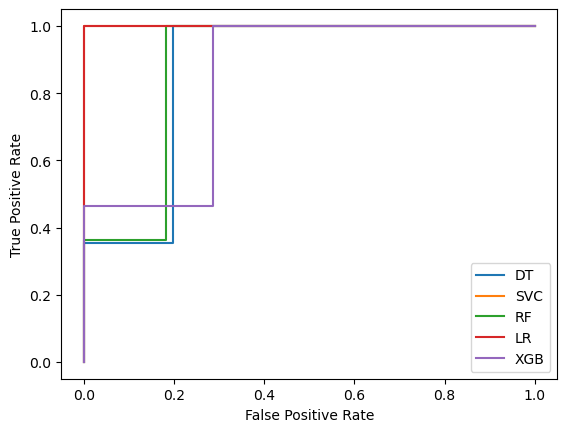

In [93]:
class_report_plot(y_test, dt_pred)
class_report_plot(y_test, svm_pred)
class_report_plot(y_test, rf_pred)
class_report_plot(y_test, lr_pred)
class_report_plot(y_test, xgb_pred)

### Performance w/ full feature set 

If the full feature set training takes too long, use the individual classifiers to determine any potential bottleneck

In [ ]:
shap_flag = 0 # set to 1 if SHAP analyses is required

n_iter = 100 # num of iterations
test_size = 0.3
num_of_classifiers = 5

# Initialize lists to store evaluation metrics for each model
dt_accuracy, svm_accuracy, rf_accuracy, lr_accuracy, xgb_accuracy= [[] for _ in range(num_of_classifiers)]
dt_precision, svm_precision, rf_precision, lr_precision, xgb_precision = [[] for _ in range(num_of_classifiers)]
dt_recall, svm_recall, rf_recall, lr_recall, xgb_recall = [[] for _ in range(num_of_classifiers)]
dt_f1, svm_f1, rf_f1, lr_f1,xgb_f1  =  [[] for _ in range(num_of_classifiers)]
dt_auc, svm_auc, rf_auc, lr_auc, xgb_auc = [[] for _ in range(num_of_classifiers)]
all_dt_shap_values,all_svm_shap_values, all_rf_shap_values, all_lr_shap_values, all_xgb_shap_values  =  [[] for _ in range(num_of_classifiers)]
all_dt_shap_values_padded, all_svm_shap_values_padded, all_rf_shap_values_padded, all_lr_shap_values_padded, all_xgb_shap_values_padded =  [[] for _ in range(num_of_classifiers)]

# Split into X,y
X = final_df.drop(['subid','mci'], axis =1)
y = final_df['mci']

skip_counter = 0 # keeps track of skipped iterations if the # of records in test set are not within expected range
fig_size  = (25, 18) 

for i in range(n_iter):

    if i == 99 and skip_counter>0:
        print(f'# of iterations skipped: {skip_counter}')
        i -= skip_counter
        skip_counter = 0 

    normal_subids = final_df.loc[final_df['mci']==0,'subid'].unique()
    mci_subids = final_df.loc[final_df['mci']==1,'subid'].unique()
    np.random.shuffle(normal_subids)
    np.random.shuffle(mci_subids)
    
    #split unique subids into train and test sets
    train_subids_n, test_subids_n = train_test_split(normal_subids, test_size = test_size, shuffle = True, random_state = i)
    train_subids_m, test_subids_m = train_test_split(mci_subids, test_size = test_size, shuffle = True, random_state = i)

    train_subids = np.append(train_subids_n, train_subids_m)
    test_subids = np.append(test_subids_n, test_subids_m)
    
    #Use train and test_subids to filter original dataframe
    train_data = final_df[final_df['subid'].isin(train_subids)]
    test_data = final_df[final_df['subid'].isin(test_subids)]

    ratio = len(train_data) / len(test_data)
    
    # Check if the ratio is within the desired range
    if ratio < 1.5 or ratio > 4: 
        skip_counter += 1
        continue

    else:
        
        X_train, y_train = train_data.drop('mci', axis=1), train_data['mci']
        X_test, y_test = test_data.drop('mci',axis=1), test_data['mci']

        # print(np.sort(test_subids_m)) # to check if test subids are unique()
        
         # Reshape the target variable y_train
        y_train = np.ravel(y_train)
        
        # Reshape the target variable y_test
        y_test = np.ravel(y_test)
        
        X_train_imputed_df = X_train.reset_index(drop=True).iloc[:,1:] # drop subid
        X_test_imputed_df = X_test.reset_index(drop=True).iloc[:,1:] 
        
        int_cols = X_train_imputed_df.columns[X_train_imputed_df.dtypes == 'int64'] 
        cat_cols = ['gender'] 
        
        # update_dtypes(X_train_imputed_df, cat_cols, 'category')
        # update_dtypes(X_test_imputed_df, cat_cols, 'category')
        
        encode_cols = [] # Columns to be one-hot encoded 

        X_train_final = preprocessing(X_train_imputed_df, encode_cols);
        X_test_final = preprocessing(X_test_imputed_df, encode_cols);
        
        # # After encoding, scarce categorical values might exist in training or testing sets alone. Fix mismatch
        # # Start by finding the column(s) missing
        test_only = list(set(X_test_final.columns) - set(X_train_final.columns))
        train_only = list(set(X_train_final.columns) - set(X_test_final.columns))    
        
        if train_only: # for encoded columns that exist in training set alone replicate in test
        
            for col in train_only:
                X_test_final[col] = 0
                copy_type = type(X_train_final.loc[0,col])
                X_test_final[col] = X_test_final[col].astype(copy_type)  # align dtypes
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        
        elif test_only: # repeat for one-hot encoded columns exclusive to test 
        
            for col in train_only:
                X_train_final[col] = 0
                copy_type = type(X_test_final.loc[0,col])
                X_train_final[col] = X_train_final[col].astype(copy_type)
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        # X_train_final = study_trend_and_add_features(X_train_final)
        # X_test_final = study_trend_and_add_features(X_test_final)
        
        # Initialize classifiers
        decision_tree = DecisionTreeClassifier( random_state=i)
        svm = SVC(C=0.1, kernel='linear', gamma =1,  random_state=i)
        random_forest = RandomForestClassifier(random_state=i)
        LR = LogisticRegression(solver='liblinear',random_state=i, max_iter = 3000, C=100, penalty = 'l2')
        #     LR = LogisticRegression(C=100, max_iter=3000, random_state=i,solver='newton-cholesky')
        xgb = XGBClassifier(random_state = i, enable_categorical=True)
        
        #Train classifiers on training data
        decision_tree.fit(X_train_final, y_train)
        svm.fit(X_train_final, y_train)
        random_forest.fit(X_train_final, y_train)
        LR.fit(X_train_final, y_train)
        xgb.fit(X_train_final, y_train)
        
        # Make predictions on the testing data
        dt_pred = decision_tree.predict(X_test_final)
        svm_pred = svm.predict(X_test_final)
        rf_pred = random_forest.predict(X_test_final)
        lr_pred = LR.predict(X_test_final)
        xgb_pred = xgb.predict(X_test_final)
        
        #calculate accuracy, precision, recall, f1 and store in list
        dt_accuracy.append(accuracy_score(y_test, dt_pred))
        svm_accuracy.append(accuracy_score(y_test, svm_pred))
        rf_accuracy.append(accuracy_score(y_test, rf_pred))
        lr_accuracy.append(accuracy_score(y_test, lr_pred))
        xgb_accuracy.append(accuracy_score(y_test, xgb_pred))
        
        dt_precision.append(precision_score(y_test, dt_pred,zero_division =0))
        svm_precision.append(precision_score(y_test, svm_pred,zero_division = 0))
        rf_precision.append(precision_score(y_test, rf_pred,zero_division = 0))
        lr_precision.append(precision_score(y_test, lr_pred,zero_division = 0))
        xgb_precision.append(precision_score(y_test, xgb_pred,zero_division = 0))
        
        dt_recall.append(recall_score(y_test, dt_pred))
        svm_recall.append(recall_score(y_test, svm_pred))
        rf_recall.append(recall_score(y_test, rf_pred))
        lr_recall.append(recall_score(y_test, lr_pred))
        xgb_recall.append(recall_score(y_test, xgb_pred))
        
        dt_f1.append(f1_score(y_test, dt_pred))
        svm_f1.append(f1_score(y_test, svm_pred))
        rf_f1.append(f1_score(y_test, rf_pred))
        lr_f1.append(f1_score(y_test, lr_pred))
        xgb_f1.append(f1_score(y_test, xgb_pred))
        
        dt_auc.append(roc_auc_score(y_test, decision_tree.predict_proba(X_test_final)[:,1]))
        svm_auc.append(roc_auc_score(y_test, svm.decision_function(X_test_final)))
        rf_auc.append(roc_auc_score(y_test, random_forest.predict_proba(X_test_final)[:,1]))
        lr_auc.append(roc_auc_score(y_test, LR.predict_proba(X_test_final)[:,1]))
        xgb_auc.append(roc_auc_score(y_test, xgb.predict_proba(X_test_final)[:,1]))

        if shap_flag:
   
            dt_explainer = shap.TreeExplainer(decision_tree)
            svm_explainer = shap.KernelExplainer(svm.predict, X_train_final) 
            rf_explainer = shap.TreeExplainer(random_forest)
            lr_explainer = shap.LinearExplainer(LR, X_train_final)
            xgb_explainer = shap.TreeExplainer(xgb)
    
    
            # Generate SHAP values for each classifier
            dt_shap_values = dt_explainer.shap_values(X_test_final)
            svm_shap_values = svm_explainer.shap_values(X_test_final)
            rf_shap_values = rf_explainer.shap_values(X_test_final)
            lr_shap_values = lr_explainer.shap_values(X_test_final)
            xgb_shap_values = xgb_explainer.shap_values(X_test_final)
            
            # Append SHAP values to lists
            all_dt_shap_values.append(dt_shap_values)
            all_svm_shap_values.append(svm_shap_values)
            all_rf_shap_values.append(rf_shap_values)
            all_lr_shap_values.append(lr_shap_values)
            all_xgb_shap_values.append(xgb_shap_values)

    
if shap_flag:    
    max_shape = max(arr.shape for arr in all_dt_shap_values)
    
    ## shap values for DT and RF are of shape (_, 2,2) whereas for the others the shape is (_,2). This is because the values are repeating within
    # each row of subarray of shape (2,2). The loops to compute the "new" values simply take the first value from each row to reshape 
    new_dt_shap_values = []
    new_rf_shap_values = []
    
    for i in range(len(all_dt_shap_values)):
        arr = all_dt_shap_values[i]
        l = [np.array([a[j,0] for j in range(arr.shape[1])]) for a in abs(arr)]
        new_dt_shap_values.append(np.asarray(l))
    
    
    for i in range(len(all_rf_shap_values)):
        arr = all_rf_shap_values[i]
        l = [np.array([a[j,0] for j in range(arr.shape[1])]) for a in abs(arr)]
        new_rf_shap_values.append(np.asarray(l))
            
    for arr in new_dt_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_dt_shap_values_padded.append(padded_arr)
    
    
    for arr in new_rf_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_rf_shap_values_padded.append(padded_arr)
    
    for arr in all_svm_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_svm_shap_values_padded.append(padded_arr)
    
    for arr in all_lr_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_lr_shap_values_padded.append(padded_arr)
    
    for arr in all_xgb_shap_values:
        # Determine the padding width for each dimension
        pad_width = [(0, max_shape[i] - arr.shape[i]) for i in range(arr.ndim)]
        padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
        all_xgb_shap_values_padded.append(padded_arr)
    
    
    # Convert the list of padded sub-arrays to a NumPy array
    all_dt_shap_values_fixed = np.array(all_dt_shap_values_padded)
    all_svm_shap_values_fixed = np.array(all_svm_shap_values_padded)
    all_rf_shap_values_fixed = np.array(all_rf_shap_values_padded)
    all_lr_shap_values_fixed = np.array(all_lr_shap_values_padded)
    all_xgb_shap_values_fixed = np.array(all_xgb_shap_values_padded)
    
    # Calculate mean SHAP values across iterations
    mean_dt_shap_values = np.mean(all_dt_shap_values_fixed, axis=0)
    mean_svm_shap_values = np.mean(all_svm_shap_values_fixed, axis=0)
    mean_rf_shap_values = np.mean(all_rf_shap_values_fixed, axis=0)
    mean_lr_shap_values = np.mean(all_lr_shap_values_fixed, axis=0)
    mean_xgb_shap_values = np.mean(all_xgb_shap_values_fixed, axis=0)
    
# Print mean and variance of evaluation metrics for each model
print(f'Accuracy statistics for {len(y)} records:')
print("Decision Tree:")
print(f"  - Mean accuracy: {np.mean(dt_accuracy):.4f}, Variance: {np.var(dt_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(dt_precision):.4f}, Variance: {np.var(dt_precision):.4f}")
print(f"  - Mean recall: {np.mean(dt_recall):.4f}, Variance: {np.var(dt_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(dt_f1):.4f}, Variance: {np.var(dt_f1):.4f}")
print(f"  - AUC: {np.mean(dt_auc):.3f}")
print("\nSVM:")
print(f"  - Mean accuracy: {np.mean(svm_accuracy):.4f}, Variance: {np.var(svm_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(svm_precision):.4f}, Variance: {np.var(svm_precision):.4f}")
print(f"  - Mean recall: {np.mean(svm_recall):.4f}, Variance: {np.var(svm_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(svm_f1):.4f}, Variance: {np.var(svm_f1):.4f}")
print(f"  - AUC: {np.mean(svm_auc):.3f}")
print("\nRandom Forest:")
print(f"  - Mean accuracy: {np.mean(rf_accuracy):.4f}, Variance: {np.var(rf_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(rf_precision):.4f}, Variance: {np.var(rf_precision):.4f}")
print(f"  - Mean recall: {np.mean(rf_recall):.4f}, Variance: {np.var(rf_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(rf_f1):.4f}, Variance: {np.var(rf_f1):.4f}")
print(f"  - AUC: {np.mean(rf_auc):.3f}")
print("\nLogistic Regression:")
print(f"  - Mean accuracy: {np.mean(lr_accuracy):.4f}, Variance: {np.var(lr_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(lr_precision):.4f}, Variance: {np.var(lr_precision):.4f}")
print(f"  - Mean recall: {np.mean(lr_recall):.4f}, Variance: {np.var(lr_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(lr_f1):.4f}, Variance: {np.var(lr_f1):.4f}")
print(f"  - AUC: {np.mean(lr_auc):.3f}")
print("\nXGBoost:")
print(f"  - Mean accuracy: {np.mean(xgb_accuracy):.4f}, Variance: {np.var(xgb_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(xgb_precision):.4f}, Variance: {np.var(xgb_precision):.4f}")
print(f"  - Mean recall: {np.mean(xgb_recall):.4f}, Variance: {np.var(xgb_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(xgb_f1):.4f}, Variance: {np.var(xgb_f1):.4f}")
print(f"  - AUC: {np.mean(xgb_auc):.3f}")



In [ ]:
class_report_plot(y_test, dt_pred)
class_report_plot(y_test, svm_pred)
class_report_plot(y_test, rf_pred)
class_report_plot(y_test, lr_pred)
class_report_plot(y_test, xgb_pred)

### Individual Classifiers

If the full feature set training takes too long, use the individual classifiers to determine any potential bottleneck

Accuracy statistics for 6014 records:
Decision Tree:
  - Mean accuracy: 0.5972, Variance: 0.0036
  - Mean precision: 0.2768, Variance: 0.0054
  - Mean recall: 0.3183, Variance: 0.0091
  - Mean F1-score: 0.2915, Variance: 0.0054
  - AUC: 0.508
              precision    recall  f1-score   support

     Non MCI       0.74      0.60      0.66      1391
         MCI       0.25      0.40      0.31       476

    accuracy                           0.55      1867
   macro avg       0.50      0.50      0.49      1867
weighted avg       0.62      0.55      0.57      1867



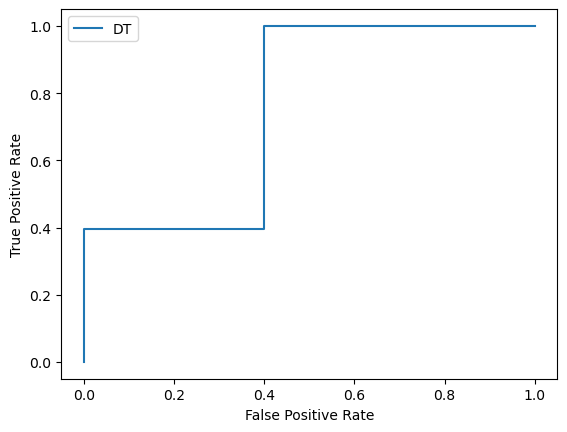

In [104]:
# DT

shap_flag = 0 # set to 1 if SHAP analyses is required

n_iter = 100 # num of iterations
test_size = 0.3
num_of_classifiers = 5

# Initialize lists to store evaluation metrics for each model
dt_accuracy, svm_accuracy, rf_accuracy, lr_accuracy, xgb_accuracy= [[] for _ in range(num_of_classifiers)]
dt_precision, svm_precision, rf_precision, lr_precision, xgb_precision = [[] for _ in range(num_of_classifiers)]
dt_recall, svm_recall, rf_recall, lr_recall, xgb_recall = [[] for _ in range(num_of_classifiers)]
dt_f1, svm_f1, rf_f1, lr_f1,xgb_f1  =  [[] for _ in range(num_of_classifiers)]
dt_auc, svm_auc, rf_auc, lr_auc, xgb_auc = [[] for _ in range(num_of_classifiers)]
all_dt_shap_values,all_svm_shap_values, all_rf_shap_values, all_lr_shap_values, all_xgb_shap_values  =  [[] for _ in range(num_of_classifiers)]
all_dt_shap_values_padded, all_svm_shap_values_padded, all_rf_shap_values_padded, all_lr_shap_values_padded, all_xgb_shap_values_padded =  [[] for _ in range(num_of_classifiers)]

# Split into X,y
X = final_df.drop(['subid','mci'], axis =1)
y = final_df['mci']

skip_counter = 0 # keeps track of skipped iterations if the # of records in test set are not within expected range
fig_size  = (25, 18) 

for i in range(n_iter):

    if i == 99 and skip_counter>0:
        print(f'# of iterations skipped: {skip_counter}')
        i -= skip_counter
        skip_counter = 0 

    normal_subids = final_df.loc[final_df['mci']==0,'subid'].unique()
    mci_subids = final_df.loc[final_df['mci']==1,'subid'].unique()
    np.random.shuffle(normal_subids)
    np.random.shuffle(mci_subids)
    
    #split unique subids into train and test sets
    train_subids_n, test_subids_n = train_test_split(normal_subids, test_size = test_size, shuffle = True, random_state = i)
    train_subids_m, test_subids_m = train_test_split(mci_subids, test_size = test_size, shuffle = True, random_state = i)

    train_subids = np.append(train_subids_n, train_subids_m)
    test_subids = np.append(test_subids_n, test_subids_m)
    
    #Use train and test_subids to filter original dataframe
    train_data = final_df[final_df['subid'].isin(train_subids)]
    test_data = final_df[final_df['subid'].isin(test_subids)]

    ratio = len(train_data) / len(test_data)

    # Check if the ratio is within the desired range
    if ratio < 1.5 or ratio > 4: 
        skip_counter += 1
        continue

    else:
        
        X_train, y_train = train_data.drop('mci', axis=1), train_data['mci']
        X_test, y_test = test_data.drop('mci',axis=1), test_data['mci']

        # print(np.sort(test_subids_m)) # to check if test subids are unique()
        
         # Reshape the target variable y_train
        y_train = np.ravel(y_train)
        
        # Reshape the target variable y_test
        y_test = np.ravel(y_test)
        
        X_train_imputed_df = X_train.reset_index(drop=True).iloc[:,1:] # drop subid
        X_test_imputed_df = X_test.reset_index(drop=True).iloc[:,1:] 
        
        int_cols = X_train_imputed_df.columns[X_train_imputed_df.dtypes == 'int64'] 
        cat_cols = ['gender'] 
        
        # update_dtypes(X_train_imputed_df, int_cols, 'int64')
        # update_dtypes(X_train_imputed_df, cat_cols, 'category')
        
        # update_dtypes(X_test_imputed_df, int_cols, 'int64')
        # update_dtypes(X_test_imputed_df, cat_cols, 'category')
        
        encode_cols = [] # Columns to be one-hot encoded 

        X_train_final = preprocessing(X_train_imputed_df, encode_cols);
        X_test_final = preprocessing(X_test_imputed_df, encode_cols);
        
        # # After encoding, scarce categorical values might exist in training or testing sets alone. Fix mismatch
        # # Start by finding the column(s) missing
        test_only = list(set(X_test_final.columns) - set(X_train_final.columns))
        train_only = list(set(X_train_final.columns) - set(X_test_final.columns))    
        
        # Initialize classifiers
        decision_tree = DecisionTreeClassifier( random_state=i)
        
        #Train classifiers on training data
        decision_tree.fit(X_train_final, y_train)

        # Make predictions on the testing data
        dt_pred = decision_tree.predict(X_test_final)
        
        #calculate accuracy, precision, recall, f1 and store in list
        dt_accuracy.append(accuracy_score(y_test, dt_pred))
        
        dt_precision.append(precision_score(y_test, dt_pred,zero_division =0))

        dt_recall.append(recall_score(y_test, dt_pred))

        dt_f1.append(f1_score(y_test, dt_pred))
        
        dt_auc.append(roc_auc_score(y_test, decision_tree.predict_proba(X_test_final)[:,1]))


    
# Print mean and variance of evaluation metrics for each model
print(f'Accuracy statistics for {len(y)} records:')
print("Decision Tree:")
print(f"  - Mean accuracy: {np.mean(dt_accuracy):.4f}, Variance: {np.var(dt_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(dt_precision):.4f}, Variance: {np.var(dt_precision):.4f}")
print(f"  - Mean recall: {np.mean(dt_recall):.4f}, Variance: {np.var(dt_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(dt_f1):.4f}, Variance: {np.var(dt_f1):.4f}")
print(f"  - AUC: {np.mean(dt_auc):.3f}")

class_report_plot(y_test, dt_pred)

In [ ]:
# SVC

shap_flag = 0 # set to 1 if SHAP analyses is required

n_iter = 100 # num of iterations
test_size = 0.3
num_of_classifiers = 5

# Initialize lists to store evaluation metrics for each model
dt_accuracy, svm_accuracy, rf_accuracy, lr_accuracy, xgb_accuracy= [[] for _ in range(num_of_classifiers)]
dt_precision, svm_precision, rf_precision, lr_precision, xgb_precision = [[] for _ in range(num_of_classifiers)]
dt_recall, svm_recall, rf_recall, lr_recall, xgb_recall = [[] for _ in range(num_of_classifiers)]
dt_f1, svm_f1, rf_f1, lr_f1,xgb_f1  =  [[] for _ in range(num_of_classifiers)]
dt_auc, svm_auc, rf_auc, lr_auc, xgb_auc = [[] for _ in range(num_of_classifiers)]
all_dt_shap_values,all_svm_shap_values, all_rf_shap_values, all_lr_shap_values, all_xgb_shap_values  =  [[] for _ in range(num_of_classifiers)]
all_dt_shap_values_padded, all_svm_shap_values_padded, all_rf_shap_values_padded, all_lr_shap_values_padded, all_xgb_shap_values_padded =  [[] for _ in range(num_of_classifiers)]

# Split into X,y
X = final_df.drop(['subid','mci'], axis =1)
y = final_df['mci']

skip_counter = 0 # keeps track of skipped iterations if the # of records in test set are not within expected range
fig_size  = (25, 18) 

for i in range(n_iter):

    if i == 99 and skip_counter>0:
        print(f'# of iterations skipped: {skip_counter}')
        i -= skip_counter
        skip_counter = 0 

    normal_subids = final_df.loc[final_df['mci']==0,'subid'].unique()
    mci_subids = final_df.loc[final_df['mci']==1,'subid'].unique()
    np.random.shuffle(normal_subids)
    np.random.shuffle(mci_subids)
    
    #split unique subids into train and test sets
    train_subids_n, test_subids_n = train_test_split(normal_subids, test_size = test_size, shuffle = True, random_state = i)
    train_subids_m, test_subids_m = train_test_split(mci_subids, test_size = test_size, shuffle = True, random_state = i)

    train_subids = np.append(train_subids_n, train_subids_m)
    test_subids = np.append(test_subids_n, test_subids_m)
    
    #Use train and test_subids to filter original dataframe
    train_data = final_df[final_df['subid'].isin(train_subids)]
    test_data = final_df[final_df['subid'].isin(test_subids)]

    ratio = len(train_data) / len(test_data)

    
    # Check if the ratio is within the desired range
    if ratio < 1.5 or ratio > 4: 
        skip_counter += 1
        continue

    else:
        
        X_train, y_train = train_data.drop('mci', axis=1), train_data['mci']
        X_test, y_test = test_data.drop('mci',axis=1), test_data['mci']

        # print(np.sort(test_subids_m)) # to check if test subids are unique()
        
         # Reshape the target variable y_train
        y_train = np.ravel(y_train)
        
        # Reshape the target variable y_test
        y_test = np.ravel(y_test)
        
        X_train_imputed_df = X_train.reset_index(drop=True).iloc[:,1:] # drop subid
        X_test_imputed_df = X_test.reset_index(drop=True).iloc[:,1:] 
        
        int_cols = X_train_imputed_df.columns[X_train_imputed_df.dtypes == 'int64'] 
        cat_cols = ['gender'] 
        
        # update_dtypes(X_train_imputed_df, cat_cols, 'category')
        # update_dtypes(X_test_imputed_df, cat_cols, 'category')
        
        encode_cols = [] # Columns to be one-hot encoded 

        X_train_final = preprocessing(X_train_imputed_df, encode_cols);
        X_test_final = preprocessing(X_test_imputed_df, encode_cols);
        
        # # After encoding, scarce categorical values might exist in training or testing sets alone. Fix mismatch
        # # Start by finding the column(s) missing
        test_only = list(set(X_test_final.columns) - set(X_train_final.columns))
        train_only = list(set(X_train_final.columns) - set(X_test_final.columns))    
        
        if train_only: # for encoded columns that exist in training set alone replicate in test
        
            for col in train_only:
                X_test_final[col] = 0
                copy_type = type(X_train_final.loc[0,col])
                X_test_final[col] = X_test_final[col].astype(copy_type)  # align dtypes
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        
        elif test_only: # repeat for one-hot encoded columns exclusive to test 
        
            for col in train_only:
                X_train_final[col] = 0
                copy_type = type(X_test_final.loc[0,col])
                X_train_final[col] = X_train_final[col].astype(copy_type)
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        # X_train_final = study_trend_and_add_features(X_train_final)
        # X_test_final = study_trend_and_add_features(X_test_final)
        
        # Initialize classifiers

        svm = SVC(C=0.1, kernel='poly', degree = 2,  random_state=i)
        svm.fit(X_train_final, y_train)        
        svm_pred = svm.predict(X_test_final)
        svm_accuracy.append(accuracy_score(y_test, svm_pred))
        svm_precision.append(precision_score(y_test, svm_pred,zero_division = 0))
        svm_f1.append(f1_score(y_test, svm_pred))
        svm_auc.append(roc_auc_score(y_test, svm.decision_function(X_test_final)))
        
print(f'Accuracy statistics for {len(y)} records:')
print("\nSVM:")
print(f"  - Mean accuracy: {np.mean(svm_accuracy):.4f}, Variance: {np.var(svm_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(svm_precision):.4f}, Variance: {np.var(svm_precision):.4f}")
print(f"  - Mean recall: {np.mean(svm_recall):.4f}, Variance: {np.var(svm_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(svm_f1):.4f}, Variance: {np.var(svm_f1):.4f}")
print(f"  - AUC: {np.mean(svm_auc):.3f}")

class_report_plot(y_test, svm_pred)


Random Forest:
  - Mean accuracy: 0.6894, Variance: 0.0013
  - Mean precision: 0.3198, Variance: 0.0156
  - Mean recall: 0.1404, Variance: 0.0048
  - Mean F1-score: 0.1873, Variance: 0.0062
  - AUC: 0.522
              precision    recall  f1-score   support

     Non MCI       0.72      0.88      0.79      1387
         MCI       0.23      0.09      0.13       524

    accuracy                           0.67      1911
   macro avg       0.48      0.49      0.46      1911
weighted avg       0.59      0.67      0.61      1911



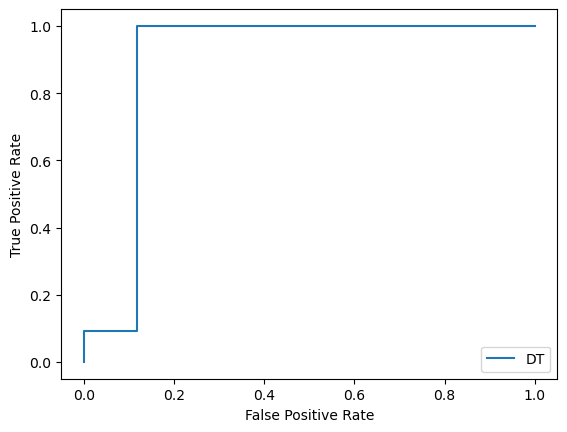

In [105]:
# RF

shap_flag = 0 # set to 1 if SHAP analyses is required

n_iter = 100 # num of iterations
test_size = 0.3
num_of_classifiers = 5

# Initialize lists to store evaluation metrics for each model
dt_accuracy, svm_accuracy, rf_accuracy, lr_accuracy, xgb_accuracy= [[] for _ in range(num_of_classifiers)]
dt_precision, svm_precision, rf_precision, lr_precision, xgb_precision = [[] for _ in range(num_of_classifiers)]
dt_recall, svm_recall, rf_recall, lr_recall, xgb_recall = [[] for _ in range(num_of_classifiers)]
dt_f1, svm_f1, rf_f1, lr_f1,xgb_f1  =  [[] for _ in range(num_of_classifiers)]
dt_auc, svm_auc, rf_auc, lr_auc, xgb_auc = [[] for _ in range(num_of_classifiers)]
all_dt_shap_values,all_svm_shap_values, all_rf_shap_values, all_lr_shap_values, all_xgb_shap_values  =  [[] for _ in range(num_of_classifiers)]
all_dt_shap_values_padded, all_svm_shap_values_padded, all_rf_shap_values_padded, all_lr_shap_values_padded, all_xgb_shap_values_padded =  [[] for _ in range(num_of_classifiers)]

# Split into X,y
X = final_df.drop(['subid','mci'], axis =1)
y = final_df['mci']

skip_counter = 0 # keeps track of skipped iterations if the # of records in test set are not within expected range
fig_size  = (25, 18) 

for i in range(n_iter):

    if i == 99 and skip_counter>0:
        print(f'# of iterations skipped: {skip_counter}')
        i -= skip_counter
        skip_counter = 0 

    normal_subids = final_df.loc[final_df['mci']==0,'subid'].unique()
    mci_subids = final_df.loc[final_df['mci']==1,'subid'].unique()
    np.random.shuffle(normal_subids)
    np.random.shuffle(mci_subids)
    
    #split unique subids into train and test sets
    train_subids_n, test_subids_n = train_test_split(normal_subids, test_size = test_size, shuffle = True, random_state = i)
    train_subids_m, test_subids_m = train_test_split(mci_subids, test_size = test_size, shuffle = True, random_state = i)

    train_subids = np.append(train_subids_n, train_subids_m)
    test_subids = np.append(test_subids_n, test_subids_m)
    
    #Use train and test_subids to filter original dataframe
    train_data = final_df[final_df['subid'].isin(train_subids)]
    test_data = final_df[final_df['subid'].isin(test_subids)]

    ratio = len(train_data) / len(test_data)

    
    # Check if the ratio is within the desired range
    if ratio < 1.5 or ratio > 4: 
        skip_counter += 1
        continue

    else:
        
        X_train, y_train = train_data.drop('mci', axis=1), train_data['mci']
        X_test, y_test = test_data.drop('mci',axis=1), test_data['mci']

        # print(np.sort(test_subids_m)) # to check if test subids are unique()
        
         # Reshape the target variable y_train
        y_train = np.ravel(y_train)
        
        # Reshape the target variable y_test
        y_test = np.ravel(y_test)
        
        X_train_imputed_df = X_train.reset_index(drop=True).iloc[:,1:] # drop subid
        X_test_imputed_df = X_test.reset_index(drop=True).iloc[:,1:] 
        
        int_cols = X_train_imputed_df.columns[X_train_imputed_df.dtypes == 'int64'] 
        cat_cols = ['gender'] 
        
        # update_dtypes(X_train_imputed_df, cat_cols, 'category')
        # update_dtypes(X_test_imputed_df, cat_cols, 'category')
        
        encode_cols = [] # Columns to be one-hot encoded 

        X_train_final = preprocessing(X_train_imputed_df, encode_cols);
        X_test_final = preprocessing(X_test_imputed_df, encode_cols);
        
        # # After encoding, scarce categorical values might exist in training or testing sets alone. Fix mismatch
        # # Start by finding the column(s) missing
        test_only = list(set(X_test_final.columns) - set(X_train_final.columns))
        train_only = list(set(X_train_final.columns) - set(X_test_final.columns))    
        
        if train_only: # for encoded columns that exist in training set alone replicate in test
        
            for col in train_only:
                X_test_final[col] = 0
                copy_type = type(X_train_final.loc[0,col])
                X_test_final[col] = X_test_final[col].astype(copy_type)  # align dtypes
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        
        elif test_only: # repeat for one-hot encoded columns exclusive to test 
        
            for col in train_only:
                X_train_final[col] = 0
                copy_type = type(X_test_final.loc[0,col])
                X_train_final[col] = X_train_final[col].astype(copy_type)
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        # X_train_final = study_trend_and_add_features(X_train_final)
        # X_test_final = study_trend_and_add_features(X_test_final)
        
        random_forest = RandomForestClassifier(random_state=i)

        random_forest.fit(X_train_final, y_train)

        rf_pred = random_forest.predict(X_test_final)

        rf_accuracy.append(accuracy_score(y_test, rf_pred))

        rf_precision.append(precision_score(y_test, rf_pred,zero_division = 0))

        rf_recall.append(recall_score(y_test, rf_pred))

        rf_f1.append(f1_score(y_test, rf_pred))

        rf_auc.append(roc_auc_score(y_test, random_forest.predict_proba(X_test_final)[:,1]))
    

print("\nRandom Forest:")
print(f"  - Mean accuracy: {np.mean(rf_accuracy):.4f}, Variance: {np.var(rf_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(rf_precision):.4f}, Variance: {np.var(rf_precision):.4f}")
print(f"  - Mean recall: {np.mean(rf_recall):.4f}, Variance: {np.var(rf_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(rf_f1):.4f}, Variance: {np.var(rf_f1):.4f}")
print(f"  - AUC: {np.mean(rf_auc):.3f}")

class_report_plot(y_test, rf_pred)


Logistic Regression:
  - Mean accuracy: 0.7136, Variance: 0.0003
  - Mean precision: 0.2229, Variance: 0.0178
  - Mean recall: 0.0389, Variance: 0.0008
  - Mean F1-score: 0.0640, Variance: 0.0020
  - AUC: 0.488
              precision    recall  f1-score   support

     Non MCI       0.75      0.94      0.83      1360
         MCI       0.23      0.06      0.10       450

    accuracy                           0.72      1810
   macro avg       0.49      0.50      0.46      1810
weighted avg       0.62      0.72      0.65      1810



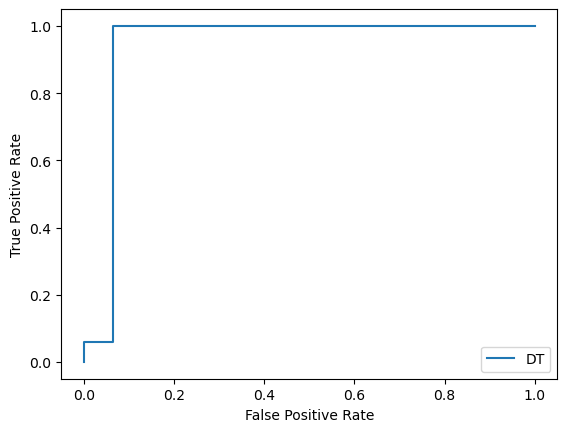

In [106]:
# LR

shap_flag = 0 # set to 1 if SHAP analyses is required

n_iter = 100 # num of iterations
test_size = 0.3
num_of_classifiers = 5

# Initialize lists to store evaluation metrics for each model
dt_accuracy, svm_accuracy, rf_accuracy, lr_accuracy, xgb_accuracy= [[] for _ in range(num_of_classifiers)]
dt_precision, svm_precision, rf_precision, lr_precision, xgb_precision = [[] for _ in range(num_of_classifiers)]
dt_recall, svm_recall, rf_recall, lr_recall, xgb_recall = [[] for _ in range(num_of_classifiers)]
dt_f1, svm_f1, rf_f1, lr_f1,xgb_f1  =  [[] for _ in range(num_of_classifiers)]
dt_auc, svm_auc, rf_auc, lr_auc, xgb_auc = [[] for _ in range(num_of_classifiers)]
all_dt_shap_values,all_svm_shap_values, all_rf_shap_values, all_lr_shap_values, all_xgb_shap_values  =  [[] for _ in range(num_of_classifiers)]
all_dt_shap_values_padded, all_svm_shap_values_padded, all_rf_shap_values_padded, all_lr_shap_values_padded, all_xgb_shap_values_padded =  [[] for _ in range(num_of_classifiers)]

# Split into X,y
X = final_df.drop(['subid','mci'], axis =1)
y = final_df['mci']

skip_counter = 0 # keeps track of skipped iterations if the # of records in test set are not within expected range
fig_size  = (25, 18) 

for i in range(n_iter):

    if i == 99 and skip_counter>0:
        print(f'# of iterations skipped: {skip_counter}')
        i -= skip_counter
        skip_counter = 0 
        
    normal_subids = final_df.loc[final_df['mci']==0,'subid'].unique()
    mci_subids = final_df.loc[final_df['mci']==1,'subid'].unique()
    np.random.shuffle(normal_subids)
    np.random.shuffle(mci_subids)
    
    #split unique subids into train and test sets
    train_subids_n, test_subids_n = train_test_split(normal_subids, test_size = test_size, shuffle = True, random_state = i)
    train_subids_m, test_subids_m = train_test_split(mci_subids, test_size = test_size, shuffle = True, random_state = i)

    train_subids = np.append(train_subids_n, train_subids_m)
    test_subids = np.append(test_subids_n, test_subids_m)
    
    #Use train and test_subids to filter original dataframe
    train_data = final_df[final_df['subid'].isin(train_subids)]
    test_data = final_df[final_df['subid'].isin(test_subids)]

    ratio = len(train_data) / len(test_data)

    
    # Check if the ratio is within the desired range
    if ratio < 1.5 or ratio > 4: 
        skip_counter += 1
        continue

    else:
        
        X_train, y_train = train_data.drop('mci', axis=1), train_data['mci']
        X_test, y_test = test_data.drop('mci',axis=1), test_data['mci']

        # print(np.sort(test_subids_m)) # to check if test subids are unique()
        
         # Reshape the target variable y_train
        y_train = np.ravel(y_train)
        
        # Reshape the target variable y_test
        y_test = np.ravel(y_test)
        
        X_train_imputed_df = X_train.reset_index(drop=True).iloc[:,1:] # drop subid
        X_test_imputed_df = X_test.reset_index(drop=True).iloc[:,1:] 
        
        int_cols = X_train_imputed_df.columns[X_train_imputed_df.dtypes == 'int64'] 
        cat_cols = ['gender'] 
        
        # update_dtypes(X_train_imputed_df, cat_cols, 'category')
        # update_dtypes(X_test_imputed_df, cat_cols, 'category')
        
        encode_cols = [] # Columns to be one-hot encoded 

        X_train_final = preprocessing(X_train_imputed_df, encode_cols);
        X_test_final = preprocessing(X_test_imputed_df, encode_cols);
        
        # # After encoding, scarce categorical values might exist in training or testing sets alone. Fix mismatch
        # # Start by finding the column(s) missing
        test_only = list(set(X_test_final.columns) - set(X_train_final.columns))
        train_only = list(set(X_train_final.columns) - set(X_test_final.columns))    
        
        if train_only: # for encoded columns that exist in training set alone replicate in test
        
            for col in train_only:
                X_test_final[col] = 0
                copy_type = type(X_train_final.loc[0,col])
                X_test_final[col] = X_test_final[col].astype(copy_type)  # align dtypes
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        
        elif test_only: # repeat for one-hot encoded columns exclusive to test 
        
            for col in train_only:
                X_train_final[col] = 0
                copy_type = type(X_test_final.loc[0,col])
                X_train_final[col] = X_train_final[col].astype(copy_type)
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        # X_train_final = study_trend_and_add_features(X_train_final)
        # X_test_final = study_trend_and_add_features(X_test_final)
        
        LR = LogisticRegression(solver='liblinear',random_state=i, max_iter = 3000, C=100, penalty = 'l2')

        LR.fit(X_train_final, y_train)

        lr_pred = LR.predict(X_test_final)

        lr_accuracy.append(accuracy_score(y_test, lr_pred))

        lr_precision.append(precision_score(y_test, lr_pred,zero_division = 0))

        lr_recall.append(recall_score(y_test, lr_pred))

        lr_f1.append(f1_score(y_test, lr_pred))

        lr_auc.append(roc_auc_score(y_test, LR.predict_proba(X_test_final)[:,1]))



print("\nLogistic Regression:")
print(f"  - Mean accuracy: {np.mean(lr_accuracy):.4f}, Variance: {np.var(lr_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(lr_precision):.4f}, Variance: {np.var(lr_precision):.4f}")
print(f"  - Mean recall: {np.mean(lr_recall):.4f}, Variance: {np.var(lr_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(lr_f1):.4f}, Variance: {np.var(lr_f1):.4f}")
print(f"  - AUC: {np.mean(lr_auc):.3f}")


class_report_plot(y_test, lr_pred)


XGBoost:
  - Mean accuracy: 0.6573, Variance: 0.0021
  - Mean precision: 0.2604, Variance: 0.0130
  - Mean recall: 0.1703, Variance: 0.0074
  - Mean F1-score: 0.2007, Variance: 0.0080
  - AUC: 0.515
              precision    recall  f1-score   support

     Non MCI       0.77      0.92      0.84      1349
         MCI       0.35      0.13      0.19       437

    accuracy                           0.73      1786
   macro avg       0.56      0.53      0.51      1786
weighted avg       0.66      0.73      0.68      1786



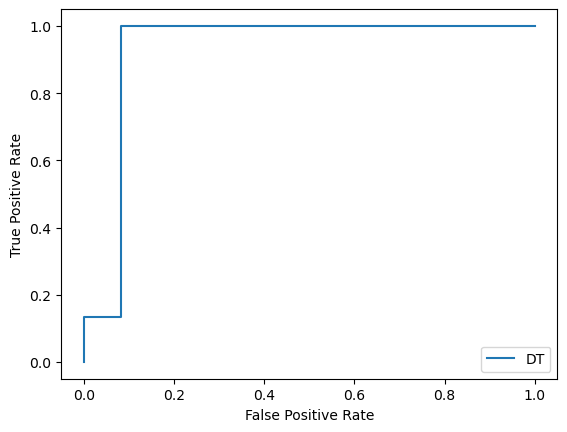

In [107]:
# XGB

shap_flag = 0 # set to 1 if SHAP analyses is required

n_iter = 100 # num of iterations
test_size = 0.3
num_of_classifiers = 5

# Initialize lists to store evaluation metrics for each model
dt_accuracy, svm_accuracy, rf_accuracy, lr_accuracy, xgb_accuracy= [[] for _ in range(num_of_classifiers)]
dt_precision, svm_precision, rf_precision, lr_precision, xgb_precision = [[] for _ in range(num_of_classifiers)]
dt_recall, svm_recall, rf_recall, lr_recall, xgb_recall = [[] for _ in range(num_of_classifiers)]
dt_f1, svm_f1, rf_f1, lr_f1,xgb_f1  =  [[] for _ in range(num_of_classifiers)]
dt_auc, svm_auc, rf_auc, lr_auc, xgb_auc = [[] for _ in range(num_of_classifiers)]
all_dt_shap_values,all_svm_shap_values, all_rf_shap_values, all_lr_shap_values, all_xgb_shap_values  =  [[] for _ in range(num_of_classifiers)]
all_dt_shap_values_padded, all_svm_shap_values_padded, all_rf_shap_values_padded, all_lr_shap_values_padded, all_xgb_shap_values_padded =  [[] for _ in range(num_of_classifiers)]

# Split into X,y
X = final_df.drop(['subid','mci'], axis =1)
y = final_df['mci']

skip_counter = 0 # keeps track of skipped iterations if the # of records in test set are not within expected range
fig_size  = (25, 18) 

for i in range(n_iter):

    if i == 99 and skip_counter>0:
        print(f'# of iterations skipped: {skip_counter}')
        i -= skip_counter
        skip_counter = 0 
    
    normal_subids = final_df.loc[final_df['mci']==0,'subid'].unique()
    mci_subids = final_df.loc[final_df['mci']==1,'subid'].unique()
    np.random.shuffle(normal_subids)
    np.random.shuffle(mci_subids)
    
    #split unique subids into train and test sets
    train_subids_n, test_subids_n = train_test_split(normal_subids, test_size = test_size, shuffle = True, random_state = i)
    train_subids_m, test_subids_m = train_test_split(mci_subids, test_size = test_size, shuffle = True, random_state = i)

    train_subids = np.append(train_subids_n, train_subids_m)
    test_subids = np.append(test_subids_n, test_subids_m)
    
    #Use train and test_subids to filter original dataframe
    train_data = final_df[final_df['subid'].isin(train_subids)]
    test_data = final_df[final_df['subid'].isin(test_subids)]

    ratio = len(train_data) / len(test_data)

    
    # Check if the ratio is within the desired range
    if ratio < 1.5 or ratio > 4: 
        skip_counter += 1
        continue

    else:
        
        X_train, y_train = train_data.drop('mci', axis=1), train_data['mci']
        X_test, y_test = test_data.drop('mci',axis=1), test_data['mci']

        # print(np.sort(test_subids_m)) # to check if test subids are unique()
        
         # Reshape the target variable y_train
        y_train = np.ravel(y_train)
        
        # Reshape the target variable y_test
        y_test = np.ravel(y_test)
        
        X_train_imputed_df = X_train.reset_index(drop=True).iloc[:,1:] # drop subid
        X_test_imputed_df = X_test.reset_index(drop=True).iloc[:,1:] 
        
        int_cols = X_train_imputed_df.columns[X_train_imputed_df.dtypes == 'int64'] 
        cat_cols = ['gender'] 
        
        # update_dtypes(X_train_imputed_df, cat_cols, 'category')
        # update_dtypes(X_test_imputed_df, cat_cols, 'category')
        
        encode_cols = [] # Columns to be one-hot encoded 

        X_train_final = preprocessing(X_train_imputed_df, encode_cols);
        X_test_final = preprocessing(X_test_imputed_df, encode_cols);
        
        # # After encoding, scarce categorical values might exist in training or testing sets alone. Fix mismatch
        # # Start by finding the column(s) missing
        test_only = list(set(X_test_final.columns) - set(X_train_final.columns))
        train_only = list(set(X_train_final.columns) - set(X_test_final.columns))    
        
        if train_only: # for encoded columns that exist in training set alone replicate in test
        
            for col in train_only:
                X_test_final[col] = 0
                copy_type = type(X_train_final.loc[0,col])
                X_test_final[col] = X_test_final[col].astype(copy_type)  # align dtypes
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        
        elif test_only: # repeat for one-hot encoded columns exclusive to test 
        
            for col in train_only:
                X_train_final[col] = 0
                copy_type = type(X_test_final.loc[0,col])
                X_train_final[col] = X_train_final[col].astype(copy_type)
                
            col_order = X_train_final.columns.tolist()               # align column order
            X_test_final = X_test_final[col_order]
        
        # X_train_final = study_trend_and_add_features(X_train_final)
        # X_test_final = study_trend_and_add_features(X_test_final)

        xgb = XGBClassifier(random_state = i, enable_categorical=True)
        
        xgb.fit(X_train_final, y_train)

        xgb_pred = xgb.predict(X_test_final)

        xgb_accuracy.append(accuracy_score(y_test, xgb_pred))

        xgb_precision.append(precision_score(y_test, xgb_pred,zero_division = 0))

        xgb_recall.append(recall_score(y_test, xgb_pred))

        xgb_f1.append(f1_score(y_test, xgb_pred))

        xgb_auc.append(roc_auc_score(y_test, xgb.predict_proba(X_test_final)[:,1]))

print("\nXGBoost:")
print(f"  - Mean accuracy: {np.mean(xgb_accuracy):.4f}, Variance: {np.var(xgb_accuracy):.4f}")
print(f"  - Mean precision: {np.mean(xgb_precision):.4f}, Variance: {np.var(xgb_precision):.4f}")
print(f"  - Mean recall: {np.mean(xgb_recall):.4f}, Variance: {np.var(xgb_recall):.4f}")
print(f"  - Mean F1-score: {np.mean(xgb_f1):.4f}, Variance: {np.var(xgb_f1):.4f}")
print(f"  - AUC: {np.mean(xgb_auc):.3f}")

class_report_plot(y_test, xgb_pred)

# Appendix

## Appendix 1:  5/19/2024

Enrich `mars.csv` with potentially useful information from `rush_additional.csv` and `rush_final_20210708.csv` to reduce number of subids lost after merge with OHSU and VA CART

### 1. Read data from `rush_additional.csv` and `rush_final_20210708.csv`
   
    - `rush_additional.csv` and `rush_final_20210708.csv` do not have gender fields, instead they have `msex` which has the same gender mapping as `mars.csv`. 

    - The 6 ids in MARS with missing gender also have missing MCI status, which can be inferred through `dcfdx`. In addition to `gender`, `dcfdx` and `mci` must be updated for the 6 subids

In [ ]:
mars = pd.read_csv(demo_path + 'mars.csv')
mars = mars.iloc[:,1:] # Dropped index column
mars['gender'].value_counts()

In [ ]:
mars_final = pd.read_csv(demo_path + 'rush_final_20210708.csv')
mars_final.rename(columns = {'home_id': 'homeid', 'sub_id': 'subid'}, inplace = True)
set(mars_final.columns) - set(mars.columns); # 323 vs 263



In [ ]:
set(mars['subid'].unique()) - set(mars_final['subid'].unique()) # MARS = 74, MARS_FINAL = 68; MARS.columns = 263, MARS_FINAL.columns = 323

In [ ]:
mars_additional = pd.read_csv(demo_path + 'rush_additional.csv') 
mars_additional.rename(columns = {'home_id': 'homeid', 'sub_id': 'subid'}, inplace = True)

mars_additional

### 2. Determine any overlap in subject IDs between the three files

In [ ]:
mars_add_in_mars = [id for id in mars_additional['subid'].unique() if id in mars['subid'].unique().astype('int64')] # MARS_ADD & MARS = 3/74
mars_final_in_mars = [id for id in mars_final['subid'].unique().astype('int64') if id in mars['subid'].unique().astype('int64')] # MARS_FINAL & MARS = 68/74
mars_add_in_final = [id for id in mars_additional['subid'].unique() if id in mars_final['subid'].unique().astype('int64')] # MARS_ADD & MARS_FINAL = 2/68
len(mars_add_in_final)

#### 5/19/2024: Read data from `rush_additional.csv` and `rush_final_20210708.csv` as we lose subjects from this cohort when combining with CART

`rush_additional.csv` and `rush_final_20210708.csv` do not have gender fields, instead they have `msex` which has the same gender mapping as `mars.csv`. 

The 6 ids in MARS with missing gender also have missing MCI status, which can be inferred through `dcfdx`. In addition to `gender`, `dcfdx` and `mci` must be updated for the 6 subids

### 3. Use `mars_additional` to update any missing values 

    - in `mars_final`
    - Repeat to update `mars`

This is because `mars_additional` has ids in common with both dfs. We can then update `mars` using `mars_final` for any differences that may occur

In [ ]:
mars_add_f = mars_additional.loc[mars_additional['subid'].isin(mars_add_in_final),mars_final.columns.intersection(mars_additional.columns)]
mars_add_f

In [ ]:
mars_final_a = mars_final.loc[mars_final['subid'].isin(mars_add_in_final),mars_final.columns.intersection(mars_additional.columns)]
mars_final_a.reset_index(drop = True, inplace = True)
mars_final_a

In [ ]:
mars_final_a.compare(mars_add_f.dropna().reset_index(drop=True), result_names = ('mars_final', 'mars_additional'))


We need to update 'age_death' for the subid in index 0 in `mars_final`

In [ ]:
index_to_update = mars_final_a.compare(mars_add_f.dropna().reset_index(drop=True), result_names = ('mars_final', 'mars_additional')).index[0]
col_to_update = mars_final_a.compare(mars_add_f.dropna().reset_index(drop=True), result_names = ('mars_final', 'mars_additional')).columns[0][0]
id_to_update = mars_final_a.loc[index_to_update,'subid'].tolist()

val_to_update = mars_add_f.dropna().reset_index(drop=True).at[index_to_update, col_to_update]


In [ ]:
mars_final.loc[mars_final['subid'] == id_to_update,col_to_update] = val_to_update
mars_final.loc[mars_final['subid'] == id_to_update,['subid',col_to_update]] 

### 4. Find differences/missing values between `mars_additional` and `mars` and update

In [ ]:
mars_subset_a = mars.loc[mars['subid'].isin(mars_add_in_mars), mars.columns.intersection(mars_additional.columns)].sort_values('subid').reset_index(drop=True)
mars_subset_a

In [ ]:
mars_add_mars = mars_additional.loc[mars_additional['subid'].isin(mars_add_in_mars), mars.columns.intersection(mars_additional.columns)].dropna().sort_values('subid').reset_index(drop=True)
mars_add_mars

In [ ]:
mars_subset_a.compare(mars_add_mars, result_names = ('mars', 'mars_additional'))

In [ ]:
index_to_update = mars_subset_a.compare(mars_add_mars, result_names = ('mars', 'mars_additional')).index[0]
multi_ind_cols = mars_subset_a.compare(mars_add_mars, result_names = ('mars', 'mars_additional')).columns[[0,2,4]]
cols_to_update = [tup[0] for tup in multi_ind_cols]
id_to_update = mars_subset_a.at[index_to_update,'subid']
vals_to_update = mars_additional.loc[mars_additional['subid'] == id_to_update,cols_to_update].dropna().values[0]

In [ ]:
for (val, col) in zip(vals_to_update,cols_to_update):
    mars.loc[mars['subid']==id_to_update,col] = val

In [ ]:
mars.loc[mars['subid']==id_to_update, ['subid'] + cols_to_update]

### 5. Enrich `1791` data using `mars_additional`

In [ ]:
mars_final_mars = mars_final.loc[mars_final['subid'].isin(mars_final_in_mars),mars.columns.intersection(mars_final.columns)].sort_values('subid')
mars_final_mars = mars_final_mars.loc[(mars_final_mars['dcfdx'].notna()) &(mars_final_mars['educ'].notna()) & (mars_final_mars['cts_mmse30'].notna())   ,:].reset_index(drop=True)
update_dtypes(mars_final_mars,['subid','homeid'],'int64')
mars_final_mars

In [ ]:
mars_final_mars.loc[(mars_final_mars['dcfdx'].notna()) &(mars_final_mars['educ'].notna()) & (mars_final_mars['cts_mmse30'].notna())   ,:].reset_index(drop=True)


In [ ]:
mars_subset_f = mars.loc[mars['subid'].isin(mars_final_in_mars), mars.columns.intersection(mars_final.columns)].sort_values('subid').reset_index(drop=True)
mars_subset_f

In [ ]:
mars_subset_f.compare(mars_final_mars, result_names=('mars', 'mars_final'))

### 6. Since we are mainly interested in updating the gender for 6 subjects in `mars`, check if `msex` is the same as `gender`

In [ ]:
mars_final_sex = mars_final.loc[mars_final['subid'].isin(mars_final_in_mars), ['subid','msex']].sort_values('subid').dropna().reset_index(drop=True)
mars_final_sex

In [ ]:
mars_sex = mars.loc[mars['subid'].isin(mars_final_in_mars), ['subid','gender']].sort_values('subid').reset_index(drop=True)
mars_sex

In [ ]:
msex_v_gender = pd.merge(mars_final_sex, mars_sex, on = 'subid') # both have the same ids
msex_v_gender

In [ ]:
msex_v_gender.iloc[:,1:].diff(axis = 1).iloc[:,-1].value_counts() 


### 7. Since we've now established that these two fields are the same. We can determine the reqd fields to be updated for `1791` 

In [ ]:
ids_wo_gender = mars.loc[mars['gender'].isna(), ['subid']].values

In [ ]:
np.intersect1d(ids_wo_gender, mars_add_in_mars)  # are they any subids whose gender can be updated?

In [ ]:
mars.loc[(mars['subid'].isin(mars_add_in_mars)) & (mars['gender'].isna()), ['subid','gender','age','dcfdx','mci']] 